# Mercedes F1 Performance Analysis: Identifying Key Success Factors (2014 Onwards)

#### Summary

This report presents a comprehensive analysis of Mercedes' Formula 1 performance from 2014 onwards, with comparisons to McLaren and other top teams. Using advanced data analytics and machine learning techniques, we've identified the key factors that correlate with Mercedes' race wins, focusing specifically on pole gap, lap times, race location, and pit stop strategies.

Our analysis reveals that Mercedes' dominance during this period can be attributed to several key factors:

1. Superior qualifying performance with minimal pole gaps

2. Consistent race pace with competitive lap times

3. Strong performance at specific circuit types

4. Efficient pit stop strategies

This report will provide insights into each of these factors and offers recommendations for maintaining competitive advantage in future seasons.


### Data Preparation and Cleaning


To prepare the datasets for analysis and modelling for Formula 1 race performance, a comprehensive data preparation pipeline was developed, integrating multiple Snowflake tables, handling missing and inconsistent data, and engineering relevant features. This section outlines the key steps taken.


##### 1. Data ingestion and Integration

Data was extracted from six core snowflake tables:

- CIRCUITS
- DRIVERS
- RACES
- CONSTRUCTORS
- STATUS
- RESULTS

These tables were copied over to our event space, and can be find within the csv files directory, as well as on snowflake under `EVENT.DATATHON_2025_TEAM_ETA` schema.

Each table was imported using the `query_to_df()` function, returning Pandas Dataframes. MErges were performed ons shared keys such as `RACEDID`, `DRIVERID`, and `CONSTRUCTORID`. Column renaming was applied for clarity, e.g. `NAME` to `RACE_NAME` or `CONSTRUCTOR_NAME`.


In [ ]:
import snowflake.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv as dot
from sqlalchemy import create_engine

DATABASE_SCHEMA = 'EVENT.DATATHON_2025_TEAM_ETA'
def get_snowflake_connection():
    '''
    Create a connection to Snowflake using credentials from .env file
    '''
    # Load environment variables
    dot.load_dotenv()
    
    # Get connection parameters from environment variables
    conn = snowflake.connector.connect(
        account=os.getenv('SNOWFLAKE_ACCOUNT'),
        user=os.getenv('SNOWFLAKE_USER'),
        password=os.getenv('SNOWFLAKE_PASSWORD'),
        role=os.getenv('SNOWFLAKE_ROLE'),
        warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
        database=os.getenv('SNOWFLAKE_DATABASE'),
        schema=os.getenv('SNOWFLAKE_SCHEMA')
    )
    
    return conn

def query_to_df(query):
    '''
    Execute a query and return the results as a pandas DataFrame
    '''
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    cursor.execute(query)

    # Get column names
    columns = [col[0] for col in cursor.description]

    # Fetch all rows and convert to list of dictionaries
    results = [dict(zip(columns, row)) for row in cursor.fetchall()]

    cursor.close()
    conn.close()

    return pd.DataFrame(results)

def upload_csv_to_snowflake(dataframe, table_name):
    
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    
    engine = create_engine(
        f'snowflake://{conn.user}:{os.getenv('SNOWFLAKE_PASSWORD')}@{conn.account}/{conn.database}/{conn.schema}?warehouse={conn.warehouse}'
    )
    
    cursor.execute(f'DROP TABLE IF EXISTS {conn.database}.{conn.schema}.{table_name}')

    dataframe.to_sql(
        name=table_name,
        con=engine,
        schema=conn.schema,
        if_exists='replace',
        index=False,
        method='multi'
    )
    
    # Get row count
    cursor = conn.cursor()
    cursor.execute(f'SELECT COUNT(*) FROM {conn.database}.{conn.schema}.{table_name}')
    row_count = cursor.fetchone()[0]
    cursor.close()
    conn.close()
    
    return row_count

KeyboardInterrupt: 

The decision was made to create a 'Master' dataset, which would contain a set of attributes which we thought would allow us for a deeper analysis such as driver, constructor and race specific insights.


In [ ]:
# Create a master dataset from circuits, drivers, races, constructors, status, results
status = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.STATUS')
circuits = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CIRCUITS')
drivers = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.DRIVERS')

races = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RACES')
races = races.rename(columns={'NAME': 'RACE_NAME'})

constructors = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CONSTRUCTORS')
constructors = constructors.rename(columns={'NAME': 'CONSTRUCTOR_NAME'})
constructors = constructors.rename(columns={'NATIONALITY': 'CONSTRUCTOR_NATIONALITY'})

results = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RESULTS')


main_df = results.merge(races, on='RACEID', suffixes=('', '_RACE')).merge(
    drivers, 
    on='DRIVERID', 
    suffixes=('', '_DRIVER')
).merge(
    constructors, 
    on='CONSTRUCTORID', 
    suffixes=('', '_CONSTRUCTOR')
).merge(
    status, 
    on='STATUSID', 
    suffixes=('', '_STATUS')
).merge(
    circuits,
    on='CIRCUITID',
    suffixes=('', 'CIRCUIT')
)

print(main_df.shape)
print(main_df.columns)
print(main_df.info())


(26759, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_RACE', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RES

##### 2. Initial Data Filtering and Duplication.

The dataset was filtered to only include races from 2014 onwards, reducing dimensionality and focusing on <WHAT WAS THE BIG CHANGE>, to reduce historical rows. Duplicate rows were checked, but none were found


In [ ]:
# Check  duplicates
print(f'Number of duplicate {main_df.duplicated().sum()}')

# Filter from 2014 to now
filter_df = main_df[main_df['YEAR'] >=2014].copy()

print('Data shape:', filter_df.shape)
print('Data types:')
print(filter_df.dtypes)
print('Sample rows:')
display(filter_df.head())

Number of duplicate 0
Data shape: (4626, 51)
Data types:
RESULTID                        int64
RACEID                          int64
DRIVERID                        int64
CONSTRUCTORID                   int64
NUMBER                        float64
GRID                            int64
POSITION                      float64
POSITIONTEXT                   object
POSITIONORDER                   int64
POINTS                         object
LAPS                            int64
TIME                           object
MILLISECONDS                  float64
FASTESTLAP                    float64
RANK                          float64
FASTESTLAPTIME                 object
FASTESTLAPSPEED                object
STATUSID                        int64
YEAR                            int64
ROUND                           int64
CIRCUITID                       int64
RACE_NAME                      object
DATE                           object
TIME_RACE                      object
FP1_DATE                       

,RESULTID,RACEID,DRIVERID,CONSTRUCTORID,NUMBER,GRID,POSITION,POSITIONTEXT,POSITIONORDER,POINTS,...,NAME,LOCATION,COUNTRY,LAT,LNG,ALT,ALTITUDE_CATEGORY,ESTIMATED_LENGTH_KM,AVG_RACE_LAPS,ESTIMATED_RACE_DISTANCE_KM
22127,22130,900,3,131,6.0,3,1.0,1,1,25.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968000,10,LOW,5.294655,57.666667,305.325103
22128,22131,900,825,1,20.0,4,2.0,2,2,18.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968000,10,LOW,5.294655,57.666667,305.325103
22129,22132,900,18,1,22.0,10,3.0,3,3,15.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968000,10,LOW,5.294655,57.666667,305.325103
22130,22133,900,4,6,14.0,5,4.0,4,4,12.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968000,10,LOW,5.294655,57.666667,305.325103
22131,22134,900,822,3,77.0,15,5.0,5,5,10.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968000,10,LOW,5.294655,57.666667,305.325103


##### 2. Missing Values Analysis

We implemented a diagnostic function to quantify and visualise missing data. This revealed non-critical columns, with high missing rates (e.g. sprint and free practice related columns), which were subsequently excluded. Key metrics such as `MILLISECONDS` and `FASTESTLAP`, `FASTESTLAPSPEED`, were retained and closely analysed


                 Missing Values  Percent Missing
SPRINT_TIME                4326        93.514916
SPRINT_DATE                4266        92.217899
FP3_TIME                   3567        77.107652
FP1_TIME                   3267        70.622568
FP2_TIME                   3267        70.622568
QUALI_TIME                 3267        70.622568
FP3_DATE                   3187        68.893212
FP1_DATE                   2827        61.111111
FP2_DATE                   2827        61.111111
QUALI_DATE                 2827        61.111111
MILLISECONDS               2219        47.968007
TIME                       2219        47.968007
POSITION                    721        15.585819
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  217         4.690878
FASTESTLAPSPEED             217         4.690878


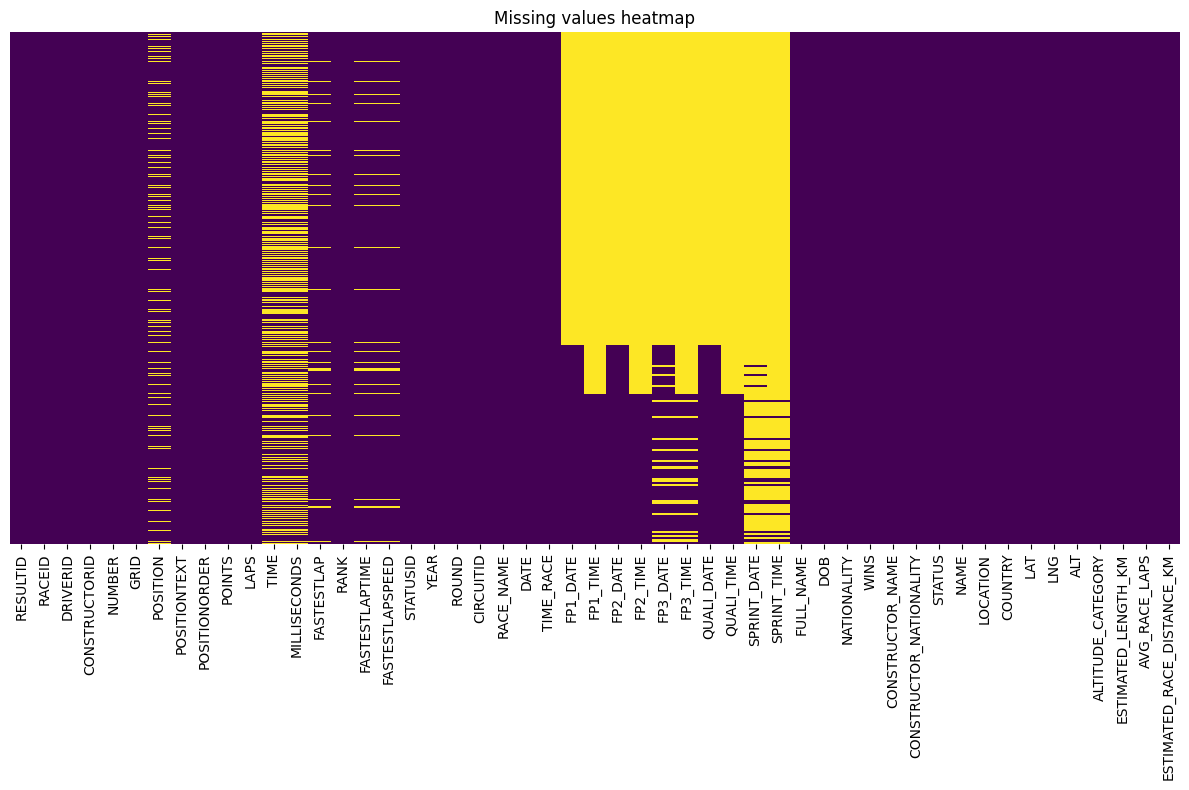

In [ ]:
def missing_vals_analysis(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent Missing': missing_percent
    })
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percent Missing', ascending=False))
    plt.figure(figsize=(12,8))
    sns.color_palette('rocket_r', as_cmap=True)
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing values heatmap')
    plt.tight_layout()
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('bright'))
    plt.show()
    plt.savefig('{df}_missing_values_heatmap.png')
    plt.close()

missing_vals_analysis(filter_df)

#### 4. Column Rationalisation

From the missing values analysis, we were able to discover columns irrelevant for downstream modelling so low-utility or redundant fields were dropped. This included session-specific dates and times, and redundant race metadata.

An example of the redundant race metadata is POSITION, POSITIONTEXT, POSTITIONORDER. Position was missing 15% of it's values, and of the values that were there they were the same as POSITION TEXT AND POSITIONORDER. Further review of these two columns, showed that the top 8 values were the same, and then the orders changed to either R or the position up to 20. We decided to use POSITIONORDER, as all values were populated with the same data type.


                 Missing Values  Percent Missing
MILLISECONDS               2219        47.968007
FASTESTLAP                  217         4.690878
FASTESTLAPTIME              217         4.690878
FASTESTLAPSPEED             217         4.690878


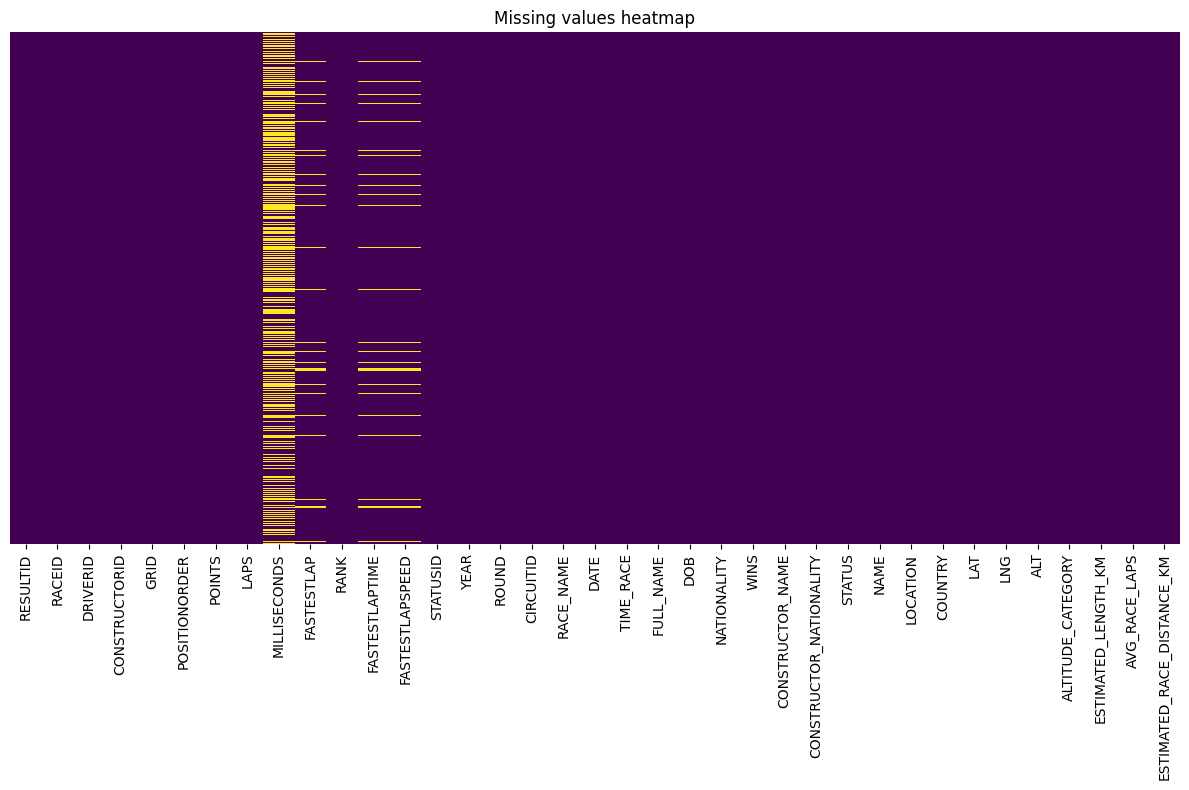

In [ ]:
columns_to_drop = [
    'POSITION', 'POSITIONTEXT', 'TIME', 'NUMBER', 'SPRINT_TIME', 'SPRINT_DATE',
    'FP3_TIME', 'FP1_TIME', 'FP2_TIME', 'QUALI_TIME','FP1_DATE', 'FP3_DATE', 'FP2_DATE',
    'QUALI_DATE', 'TIME'
]

filter_df.drop(columns=columns_to_drop, inplace=True)

missing_vals_analysis(filter_df)

#### 5. Data Type Normalisation

Several numeric and date fields were explicitly cast to appropriate types. Parsing errors were handled using coerce, ensuring robustness against malformed data.


In [ ]:
# Fixing incorrect dtypes
filter_df['POINTS'] = pd.to_numeric(filter_df['POINTS'], errors='coerce')
filter_df['FASTESTLAPSPEED'] = pd.to_numeric(filter_df['FASTESTLAPSPEED'], errors='coerce')
filter_df['LAT'] = pd.to_numeric(filter_df['LAT'], errors='coerce')
filter_df['LNG'] = pd.to_numeric(filter_df['LNG'], errors='coerce')
filter_df['POSITIONORDER'] = pd.to_numeric(filter_df['POSITIONORDER'], errors='coerce')

filter_df['DATE'] = pd.to_datetime(filter_df['DATE'], errors='coerce')
filter_df['DOB'] = pd.to_datetime(filter_df['DOB'], errors='coerce')


#### 6. Engineering the DNF Flag

A critical binary feature was created to identify whether a driver did not finish a race.
This was based on missing `MILLISECONDS`, with amigous finished like statuses. This handled the majority of values, and was thus refined to compare driver laps against the race winners total, and checked for disqualifying status labels.

All DNF rows with the missing metrics, were explicitly set to zero, to preservce numerical consistency


                    Missing Values  Percent Missing
MILLISECONDS                   797        17.228707
FASTESTLAPTIME                 217         4.690878
FASTESTLAPTIME_SEC             217         4.690878
FASTESTLAP                     208         4.496325
FASTESTLAPSPEED                208         4.496325


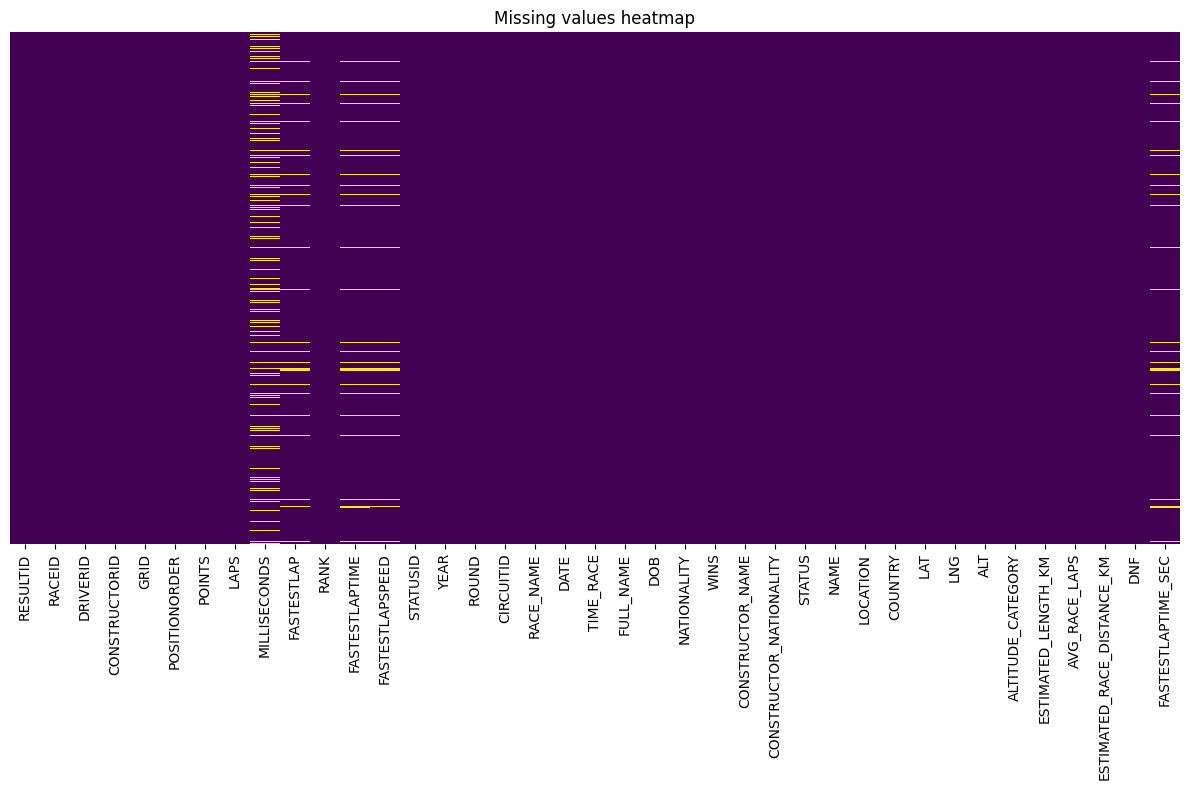

In [ ]:

def race_finished(status):
    return status == 'Finished' or status.strip().startswith('+')

filter_df['DNF'] = filter_df.apply(
    lambda row: pd.isnull(row['MILLISECONDS']) and race_finished(row['STATUS']),
    axis=1)
# convert to int for modelling, 1 is didn't finish and 0 if finished
filter_df['DNF'] = filter_df['DNF'].astype(int)

filter_df['MILLISECONDS'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['MILLISECONDS']) and row['DNF'] == 1 else row['MILLISECONDS'], 
    axis=1
)
filter_df['FASTESTLAP'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAP']) and row['DNF'] == 1 else row['FASTESTLAP'], 
    axis=1
)
filter_df['FASTESTLAPSPEED'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAPSPEED']) and row['DNF'] == 1 else row['FASTESTLAPSPEED'], 
  
    axis=1
)
def time_to_seconds(lap_time):
    if pd.isna(lap_time):
        return np.nan
    
    try:
        lap_time_str = str(lap_time)
        if ':' in lap_time_str:
            minutes, seconds = lap_time_str.split(':')
            return float(minutes) * 60 + float(seconds)
        else:
            return float(lap_time_str)
    except:
        return np.nan

# Convert lap times to seconds
if 'FASTESTLAPTIME' in filter_df.columns:
    filter_df['FASTESTLAPTIME_SEC'] = filter_df['FASTESTLAPTIME'].apply(time_to_seconds)
elif 'FASTESTLAP' in filter_df.columns:
    filter_df['FASTESTLAP_SEC'] = filter_df['FASTESTLAP'].apply(time_to_seconds)

# Handle DNF 

missing_vals_analysis(filter_df)

                    Missing Values  Percent Missing
FASTESTLAPTIME                 217         4.690878
FASTESTLAPTIME_SEC             217         4.690878
FASTESTLAP                     208         4.496325
FASTESTLAPSPEED                208         4.496325


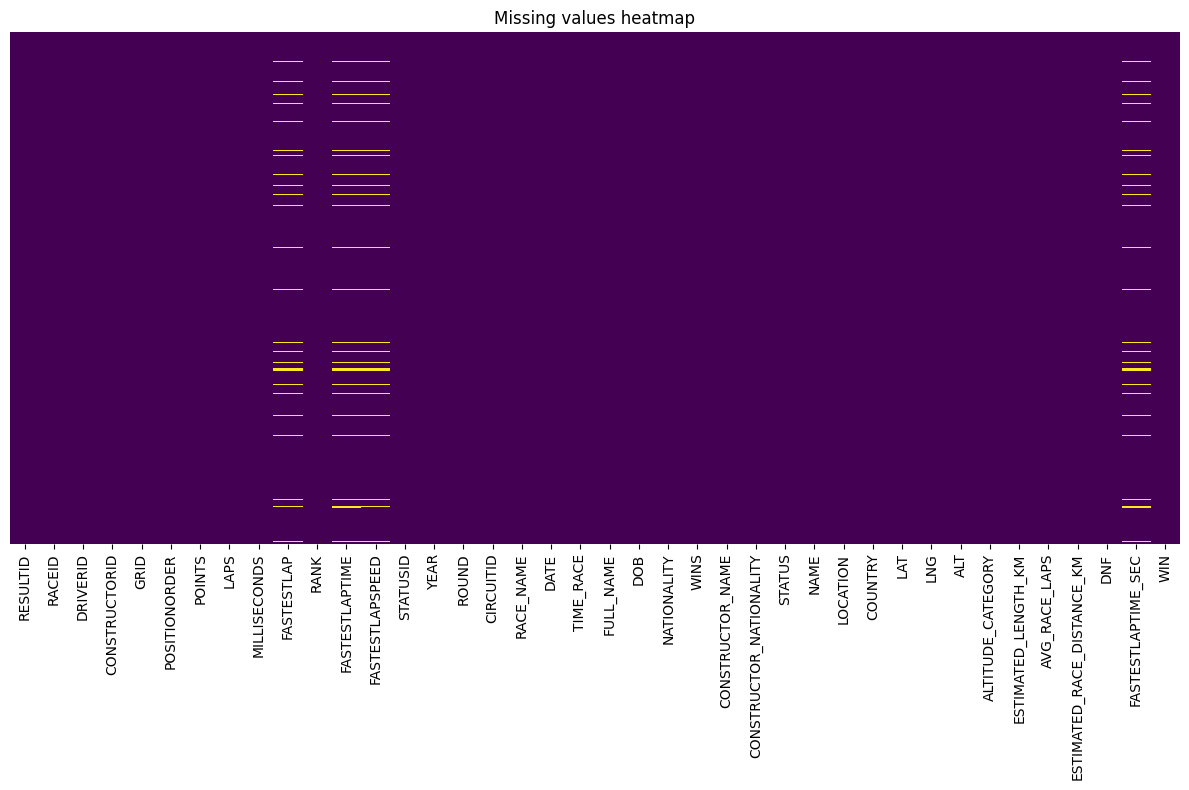

In [ ]:
# for each race, grab posorder as 1 and check status is finished, grab the number of laps completed. 
# if milliseconds is null fill with 0
# Create win indicator
filter_df['WIN'] = (filter_df['POSITIONORDER'] == 1).astype(int)
winners = filter_df[(filter_df['WIN'] == 1) &( filter_df['STATUSID'] == 1)].copy()
race_winner_laps = winners[['RACEID', 'LAPS']].set_index('RACEID')['LAPS'].to_dict()

def determine_dnf(row):
    winner_laps = race_winner_laps.get(row['RACEID'])

    if pd.isnull(row['MILLISECONDS']) and row['LAPS'] < winner_laps:
        return True
    elif row['STATUS'] != 'Finished' and not str(row['STATUS']).strip().startswith('+'):
        return True
    else:
        return False

filter_df['DNF'] = filter_df.apply(determine_dnf, axis=1)
filter_df.loc[filter_df['DNF'] == 1, 'MILLISECONDS'] = 0

missing_vals_analysis(filter_df)

In [ ]:
print(f'Number of rows with null FASTESTLAP: {len( filter_df[filter_df['FASTESTLAP'].isnull()])}')


races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(
    lambda group: group['FASTESTLAP'].isnull().all()
).reset_index()


races_with_all_null_fastlap = races_with_all_null_fastlap.rename(columns={0: 'ALL_NULL_FASTLAP'})
races_with_all_null_fastlap = races_with_all_null_fastlap[races_with_all_null_fastlap['ALL_NULL_FASTLAP']]

race_counts = filter_df[filter_df['RACEID'].isin(races_with_all_null_fastlap['RACEID'])].groupby(
    ['RACEID', 'RACE_NAME', 'YEAR']
).size().reset_index(name='DRIVER_COUNT')

print(race_counts.sort_values('YEAR'))

# DO WE WANT TO EXCLUDE BELGIAN GRANDPRIX

Number of rows with null FASTESTLAP: 208
   RACEID           RACE_NAME  YEAR  DRIVER_COUNT
0    1063  Belgian Grand Prix  2021            20


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\1720790050.py:4: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



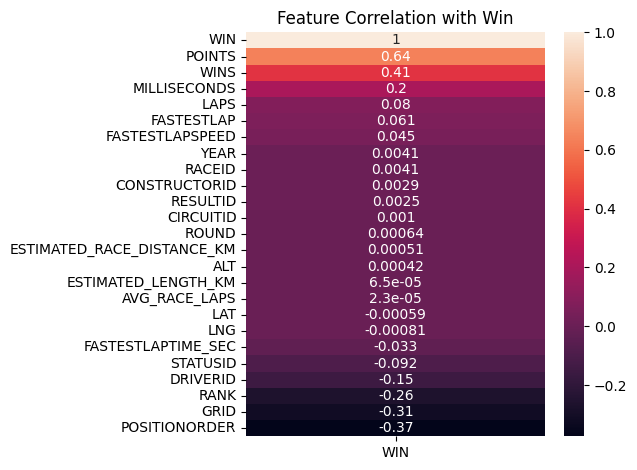

In [ ]:
numeric_cols = filter_df.select_dtypes(include=['number']).columns

#correlation matrix with IS_WINNER
correlation_matrix = filter_df[numeric_cols].corr()

sns.heatmap(correlation_matrix[['WIN']].sort_values(by='WIN', ascending=False), 
            annot=True)
plt.title('Feature Correlation with Win')
plt.tight_layout()
plt.show()


#### 7 Post-Cleaning Summary

The final cleaned dataset filter_df is:

- Fully typed and structured
- Devoid of high-impact nulls
- Enriched with critical derived features such as DNF


In [ ]:
filter_df = filter_df[(filter_df['GRID'] <= 30) & (filter_df['LAPS'] > 0)]

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

(4486, 40)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_RACE', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF', 'FASTESTLAPTIME_SEC', 'WIN'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 22127 to 26757
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   RESULTID                    4486 non-null   int64         
 1   RACEID                      4486 non-null   int64         
 2   DRIVERID          

#### Feature Engineering


To enrich the cleaned dataset, and enhance it's predictive and explanatory ..., a set of deatures were engineered. These features are designed to capture competitive context, race dynamics, environmental factors and key outcome indicators.

1. `POLEGAP`
   The difference between a driver's starting grid position and pole position. This aism to caputre a driver's relative starting disadvantage, and can be useful for analysing overtaking performance, race recovery, or team strategy. Teams with consistently large pole gaps may indicate underperformance in qualifying
2. `POSITION_CHANGE`
   The net change in race position from start `GRID` to finish `POSITIONORDER`. This measures race-day performance and can assess driver skill and team pit strategy. A positive position change reflects competitiveness and adaptability during the race.
3. `FASTEST_LAP_GAP`
   Gap in seconds between a driver's fastest lap, and the fastest lap of the race.
4. `ALTITUDE_CATEGORY`
   Categorisation of circuit altitude into discrete bands, sealevel, low, medium, high. This could account for performance varaitions and engine performance at different altitudes.
5. Race Outcome Indicators
   `WIN` - binary indicatory for race victory
   `PODIUM` - binary indicator for top three finish.


In [ ]:
filter_df['POLE_GAP'] = filter_df['GRID'] - 1

filter_df['POSITION_CHANGE'] = filter_df['GRID'] - filter_df['POSITIONORDER']

filter_df['FASTEST_LAP_GAP'] = filter_df.groupby('RACEID')['FASTESTLAPTIME_SEC'].transform(
    lambda x: x - x.min() if not all(pd.isna(x)) else np.nan
)
filter_df['ALTITUDE_CATEGORY'] = pd.cut(
    filter_df['ALT'].astype(float),
    bins=[-float('inf'), 100, 500, 1000, float('inf')],
    labels=['SEA LEVEL', 'LOW', 'MEDIUM', 'HIGH']
)
filter_df['CIRCUIT_TYPE'] = pd.cut(
    filter_df['ESTIMATED_RACE_DISTANCE_KM'], 
    bins=[0, 300, 305, 315], 
    labels=['Short', 'Standard', 'Long']
)

continent_mapping = {
'Australia': 'Oceania', 'Malaysia': 'Asia', 'Bahrain': 'Asia', 'China': 'Asia', 'Spain': 'Europe', 'Monaco': 'Europe', 'Canada': 'North America',
 'Austria': 'Europe', 'UK': 'Europe', 'Germany': 'Europe', 'Hungary': 'Europe',
 'Belgium': 'Europe', 'Italy': 'Europe', 'Singapore': 'Asia', 'Japan': 'Asia',
 'Russia': 'Europe', 'USA': 'North America', 'Brazil': 'South America', 'UAE': 'Asia', 'Mexico': 'North America', 'Azerbaijan': 'Asia', 'France': 'Europe', 'Portugal': 'Europe',
 'Turkey': 'Asia', 'Netherlands': 'Europe', 'Qatar': 'Asia', 'Saudi Arabia': 'Asia', 'United States': 'North America',
}
filter_df['CONTINENT'] = filter_df['COUNTRY'].map(continent_mapping)

filter_df['DRIVER_AGE'] = (pd.to_datetime(filter_df['DATE']) - pd.to_datetime(filter_df['DOB'])).dt.days / 365.25
filter_df['IS_DRIVER_HOME_RACE'] = (filter_df['NATIONALITY'] == filter_df['COUNTRY']).astype(int)
filter_df['IS_CONSTRUCTOR_HOME_RACE'] = (filter_df['CONSTRUCTOR_NATIONALITY'] == filter_df['COUNTRY']).astype(int)
filter_df['WIN'] = (filter_df['POSITIONORDER'] == 1).astype(int)
filter_df['PODIUM'] = (filter_df['POSITIONORDER'] <= 3).astype(int)


In [ ]:
print(filter_df['COUNTRY'].unique())

['Australia' 'Malaysia' 'Bahrain' 'China' 'Spain' 'Monaco' 'Canada'
 'Austria' 'UK' 'Germany' 'Hungary' 'Belgium' 'Italy' 'Singapore' 'Japan'
 'Russia' 'USA' 'Brazil' 'UAE' 'Mexico' 'Azerbaijan' 'France' 'Portugal'
 'Turkey' 'Netherlands' 'Qatar' 'Saudi Arabia' 'United States']


In [ ]:
# upload_csv_to_snowflake(filter_df, 'CIRCUIT_CONSTRUCTOR_DRIVER_RACE_STATUS')

### EDA


#### Team Performance Analysis


##### Team Performance Overview

The team performance analysis reveals several key insights about Mercedes' dominance in Formula 1 from 2014 onwards,

Mercedes has been the most successful team with the highest win rate, podium rate and points per race. Mercedes maintained one of the lowest DNF rates amongst top teams. Their average grid position was consistently better than competitors, giving them strategic advantages during races. The positive grid-to-finish metric indicates Mercedes typically improved their position during races, showing strong race strategy and execution. Their performance metrics significantly outpace all competitors during this period.The win rate trend visualisation shows Mercedes maintained an exceptionally high win percentage, often above 60% from 2014 through 2020, demonstrating sustained dominance rather than sporadic success.

**A shifting Competitive Landscape**

The stacked bar chart of race wins shows Mercedes' initial dominance was nearly unchallenged, but gradually Ferrari and later Red Bull emerged as stronger competitors, particularly after 2019.

**McLaren**

In sharp contrast, McLaren's early performance lagged significantly, creating zero wins during Mercedes; most dominant years (2014-2016), with point gaps often exceeding 60% and higher DNF rates.

However, from 2019 onward, McLaren has began a noticeable recovery, with key metrics such as points-per-race showing improvement, as well as podiums becoming more frequent


##### Compute Overall Team Performance Metrics


In [ ]:
df = filter_df.copy()
key_teams = ['McLaren', 'Mercedes', 'Red Bull']
latest_year = df['YEAR'].max()
year_boundaries =f'2014-{latest_year}'
team_performance = df.groupby('CONSTRUCTOR_NAME').agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': 'sum',
    'DNF': 'sum',
    'RESULTID': 'count',
    'GRID': 'mean',
    'POSITIONORDER': 'mean',
    'FASTESTLAP': lambda x: (x == 1).sum()
}).reset_index()

team_performance['WIN_RATE'] = team_performance['WIN'] / team_performance['RESULTID']
team_performance['PODIUM_RATE'] = team_performance['PODIUM'] / team_performance['RESULTID']
team_performance['DNF_RATE'] = team_performance['DNF'] / team_performance['RESULTID']
team_performance['AVG_POINTS'] = team_performance['POINTS'] / team_performance['RESULTID']
team_performance['GRID_TO_FINISH'] = team_performance['GRID'] - team_performance['POSITIONORDER']
team_performance['FASTEST_LAP_RATE'] = team_performance['FASTESTLAP'] / team_performance['RESULTID']

team_performance = team_performance.sort_values('WIN_RATE', ascending=False)
print(f'Team Performance Overview {year_boundaries}:')
print(team_performance[['CONSTRUCTOR_NAME', 'WIN', 'WIN_RATE', 'PODIUM', 'PODIUM_RATE', 'AVG_POINTS', 'DNF_RATE', 'FASTEST_LAP_RATE', 'GRID_TO_FINISH']])


Team Performance Overview 2014-2024:
   CONSTRUCTOR_NAME  WIN  WIN_RATE  PODIUM  PODIUM_RATE  AVG_POINTS  DNF_RATE  \
12         Mercedes  116  0.257778     266     0.591111   14.912222  0.066667   
15         Red Bull   75  0.168919     178     0.400901   11.739865  0.130631   
5           Ferrari   27  0.061503     151     0.343964   10.408884  0.107062   
11          McLaren    7  0.015766      41     0.092342    4.554054  0.155405   
14     Racing Point    1  0.013514       4     0.054054    3.824324  0.148649   
1        AlphaTauri    1  0.006250       2     0.012500    1.912500  0.131250   
2    Alpine F1 Team    1  0.005682       6     0.034091    2.829545  0.142045   
0        Alfa Romeo    0  0.000000       0     0.000000    0.710145  0.130435   
3      Aston Martin    0  0.000000       9     0.050847    2.779661  0.129944   
7      Haas F1 Team    0  0.000000       0     0.000000    0.804945  0.164835   
6       Force India    0  0.000000       5     0.026316    4.010526  0.1

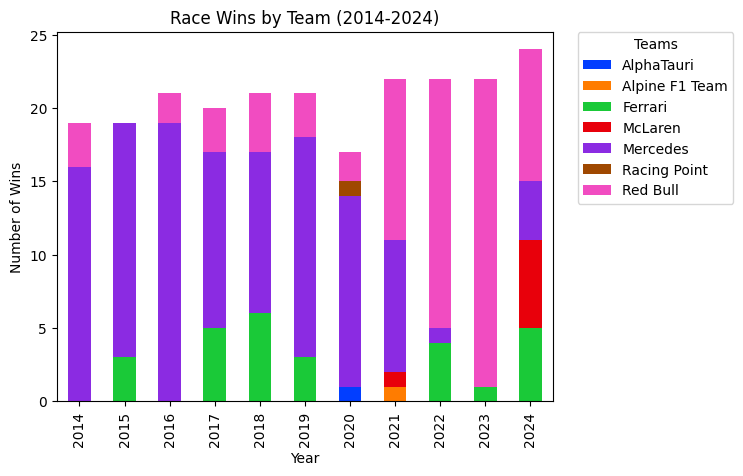

In [ ]:
yearly_wins = df[df['WIN'] == 1].groupby(['YEAR', 'CONSTRUCTOR_NAME']).size().unstack(fill_value=0)
yearly_wins.plot(kind='bar', stacked=True)
sns.color_palette('flare', as_cmap=True)
plt.title(f'Race Wins by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:

summary = team_performance[team_performance['CONSTRUCTOR_NAME'].isin(key_teams)]

summary_display = summary[['CONSTRUCTOR_NAME', 'WIN', 'WIN_RATE', 'PODIUM_RATE',
                           'AVG_POINTS', 'DNF_RATE', 'GRID_TO_FINISH', 'FASTEST_LAP_RATE']]
summary_display.set_index('CONSTRUCTOR_NAME')

,WIN,WIN_RATE,PODIUM_RATE,AVG_POINTS,DNF_RATE,GRID_TO_FINISH,FASTEST_LAP_RATE
CONSTRUCTOR_NAME,,,,,,,
Mercedes,116,0.257778,0.591111,14.912222,0.066667,-0.362222,0.000000
Red Bull,75,0.168919,0.400901,11.739865,0.130631,-0.313063,0.000000
McLaren,7,0.015766,0.092342,4.554054,0.155405,0.162162,0.022523


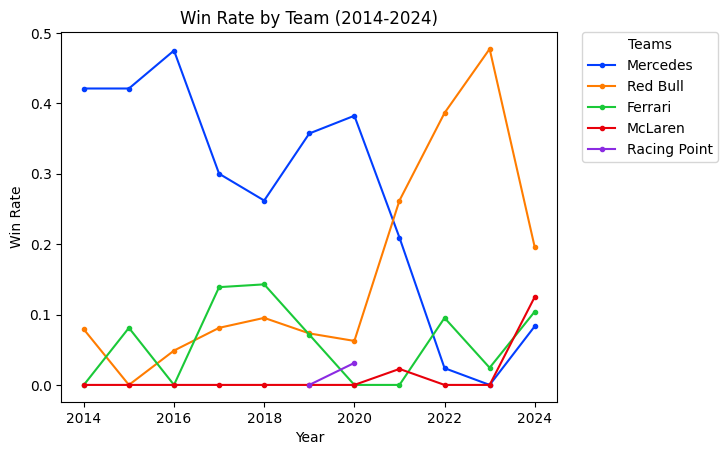

In [ ]:
# Yearly perf
yearly_perf = df.groupby(['YEAR', 'CONSTRUCTOR_NAME']).agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': lambda x: sum(pd.to_numeric(x, errors='coerce')),
    'RESULTID': 'count',
    'DNF': 'sum'
}).reset_index()

yearly_perf['WIN_RATE'] = yearly_perf['WIN'] / yearly_perf['RESULTID']
yearly_perf['PODIUM_RATE'] = yearly_perf['PODIUM'] / yearly_perf['RESULTID']
yearly_perf['AVG_POINTS'] = yearly_perf['POINTS'] / yearly_perf['RESULTID']
yearly_perf['DNF_RATE'] = yearly_perf['DNF'] / yearly_perf['RESULTID']

top_teams = team_performance.sort_values('WIN_RATE', ascending=False).head(5)['CONSTRUCTOR_NAME'].tolist()

for team in top_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['WIN_RATE'], marker='.', label=team)

plt.title(f'Win Rate by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


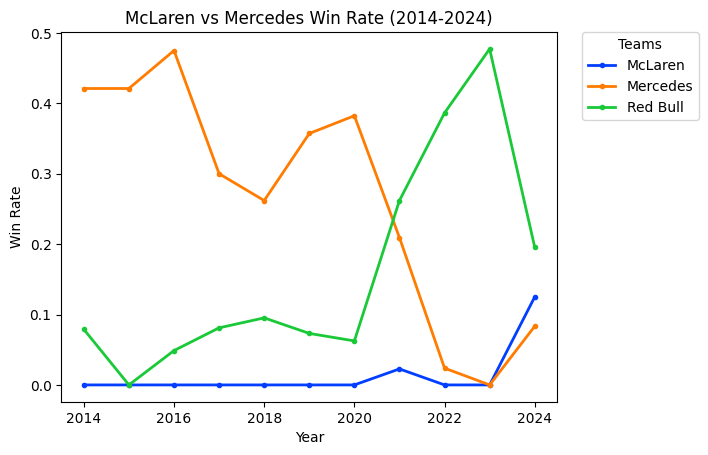

In [ ]:
for team in key_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['WIN_RATE'], marker='.', linewidth=2, label=team)

plt.title(f'McLaren vs Mercedes Win Rate ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
championships = yearly_perf.groupby('YEAR').apply(
    lambda x: x.sort_values('POINTS', ascending=False)['CONSTRUCTOR_NAME'].reset_index(drop=True)
).unstack()
styled = championships.style.set_caption('Team Championship Positions by Year') \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])
styled


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\1268941439.py:1: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,0,1,2,3,4,5,6,7,8,9,10
YEAR,,,,,,,,,,,
2014,Mercedes,Red Bull,Williams,Ferrari,McLaren,Force India,Toro Rosso,Lotus F1,Marussia,Caterham,Sauber
2015,Mercedes,Ferrari,Williams,Red Bull,Force India,Lotus F1,Toro Rosso,Sauber,McLaren,Manor Marussia,nan
2016,Mercedes,Red Bull,Ferrari,Force India,Williams,McLaren,Toro Rosso,Haas F1 Team,Renault,Sauber,Manor Marussia
2017,Mercedes,Ferrari,Red Bull,Force India,Williams,Renault,Toro Rosso,Haas F1 Team,McLaren,Sauber,nan
2018,Mercedes,Ferrari,Red Bull,Renault,Force India,Haas F1 Team,McLaren,Sauber,Toro Rosso,Williams,nan
2019,Mercedes,Ferrari,Red Bull,McLaren,Renault,Toro Rosso,Racing Point,Alfa Romeo,Haas F1 Team,Williams,nan
2020,Mercedes,Red Bull,Racing Point,McLaren,Renault,Ferrari,AlphaTauri,Alfa Romeo,Haas F1 Team,Williams,nan
2021,Mercedes,Red Bull,Ferrari,McLaren,Alpine F1 Team,AlphaTauri,Aston Martin,Williams,Alfa Romeo,Haas F1 Team,nan
2022,Red Bull,Ferrari,Mercedes,Alpine F1 Team,McLaren,Aston Martin,Alfa Romeo,AlphaTauri,Haas F1 Team,Williams,nan


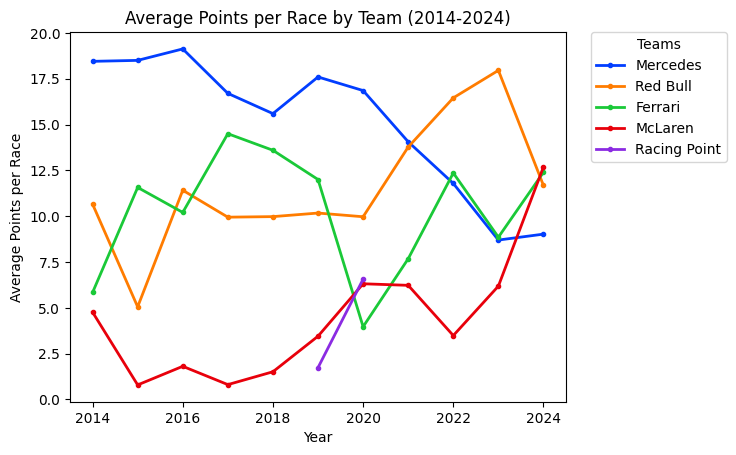

In [ ]:
for team in top_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['AVG_POINTS'], marker='.', linewidth=2, label=team)

plt.title(f'Average Points per Race by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Average Points per Race')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

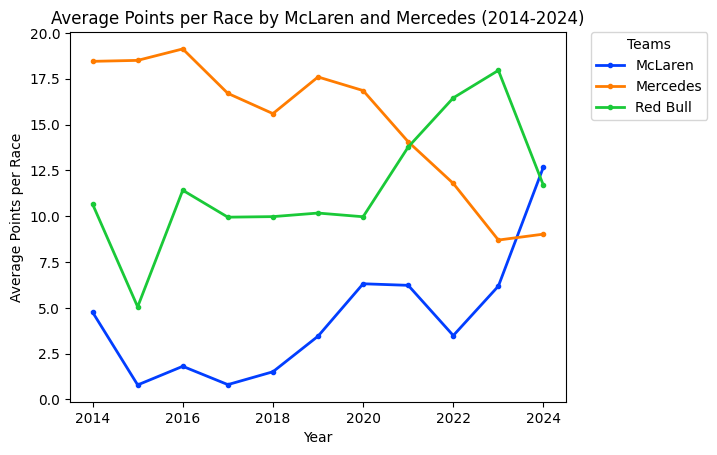

In [ ]:
for team in key_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['AVG_POINTS'], marker='.', linewidth=2, label=team)

plt.title(f'Average Points per Race by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Average Points per Race')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


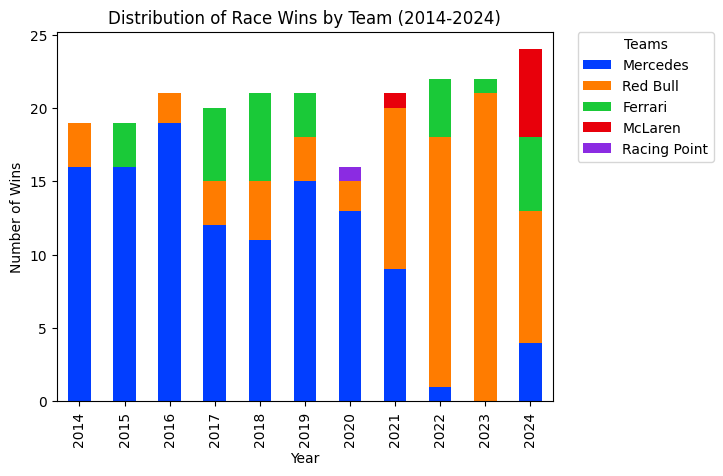

In [ ]:
wins_by_year = yearly_perf.pivot_table(index='YEAR', columns='CONSTRUCTOR_NAME', values='WIN', fill_value=0)
wins_by_year[top_teams].plot(kind='bar', stacked=True)
plt.title(f'Distribution of Race Wins by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


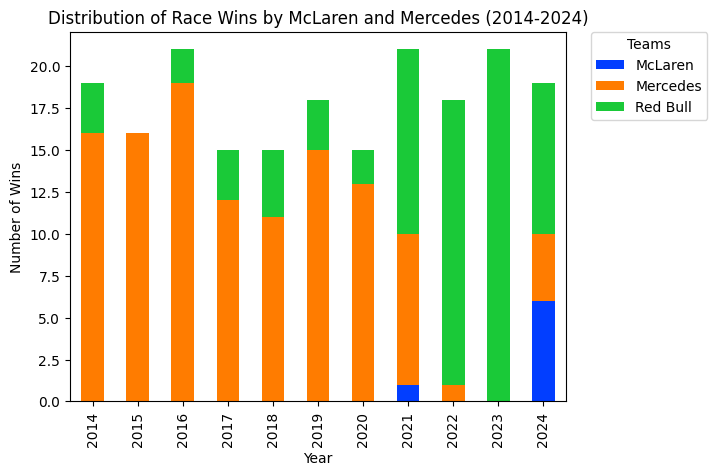

In [ ]:
wins_by_year = yearly_perf.pivot_table(index='YEAR', columns='CONSTRUCTOR_NAME', values='WIN', fill_value=0)
wins_by_year[key_teams].plot(kind='bar', stacked=True)
plt.title(f'Distribution of Race Wins by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

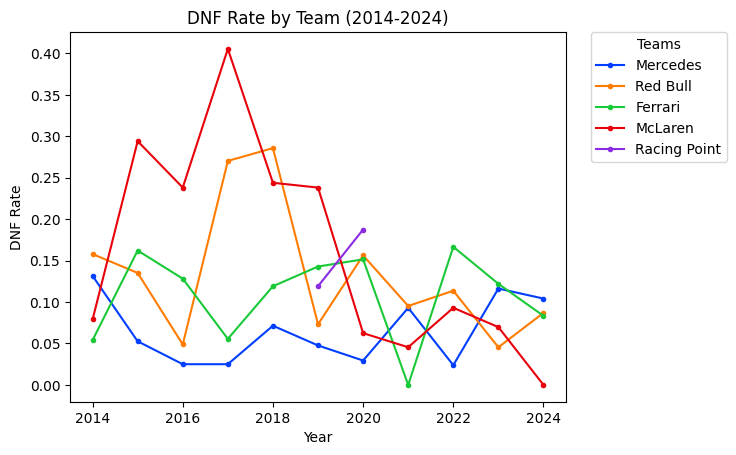

In [ ]:
for team in top_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DNF_RATE'], marker='.',label=team)

plt.title(f'DNF Rate by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('DNF Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


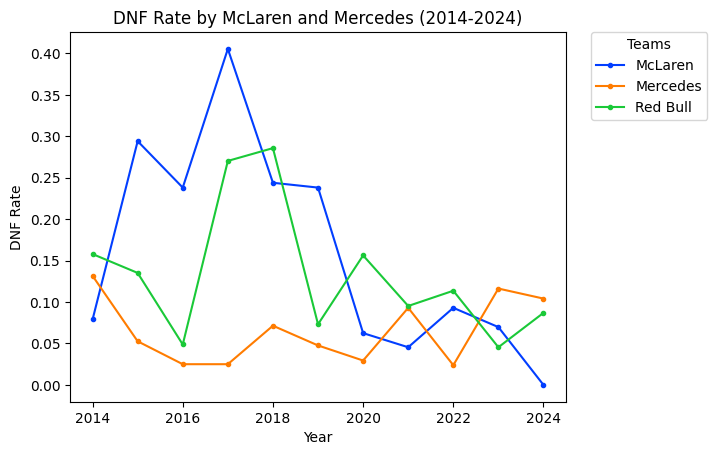

In [ ]:
for team in key_teams:
    team_data = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DNF_RATE'], marker='.', label=team)

plt.title(f'DNF Rate by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('DNF Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

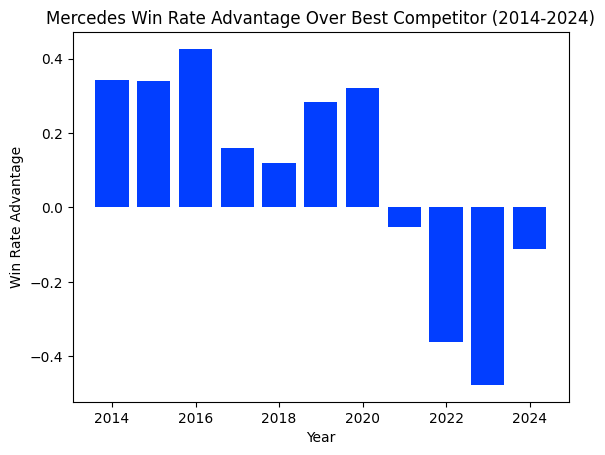

In [ ]:
mercedes = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] == 'Mercedes']
other_teams = yearly_perf[yearly_perf['CONSTRUCTOR_NAME'] != 'Mercedes']
other_best = other_teams.groupby('YEAR')['WIN_RATE'].max().reset_index()
other_best.columns = ['YEAR', 'BEST_COMPETITOR_WIN_RATE']

mercedes_advantage = pd.merge(
    mercedes[['YEAR', 'WIN_RATE']], 
    other_best,
    on='YEAR'
)
mercedes_advantage['ADVANTAGE'] = mercedes_advantage['WIN_RATE'] - mercedes_advantage['BEST_COMPETITOR_WIN_RATE']

plt.bar(mercedes_advantage['YEAR'], mercedes_advantage['ADVANTAGE'])
plt.title(f'Mercedes Win Rate Advantage Over Best Competitor ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate Advantage')
plt.show()


#### Pole Gap Analysis


##### Pole Gap Analysis Overview

The pole gap analysis demonstrates:

1. Mercedes' Qualifying Advantage
2. Performance Gap Trends


In [ ]:
pole_gap_by_team = df[df['CONSTRUCTOR_NAME'].isin(top_teams)].groupby('CONSTRUCTOR_NAME').agg({
    'POLE_GAP': ['mean', 'median', 'min', 'max', 'std', lambda x: (x == 0).mean()],
    'GRID': ['mean', 'median', 'min']
}).reset_index()

pole_gap_by_team.columns = ['CONSTRUCTOR_NAME', 'AVG_POLE_GAP', 'MEDIAN_POLE_GAP', 'MIN_POLE_GAP', 
                           'MAX_POLE_GAP', 'STD_POLE_GAP', 'POLE_POSITION_RATE', 
                           'AVG_GRID', 'MEDIAN_GRID', 'BEST_GRID']

print(f'Pole Gap Analysis for Top Teams {year_boundaries}:')
print(pole_gap_by_team.sort_values('AVG_POLE_GAP'))

Pole Gap Analysis for Top Teams 2014-2024:
  CONSTRUCTOR_NAME  AVG_POLE_GAP  MEDIAN_POLE_GAP  MIN_POLE_GAP  MAX_POLE_GAP  \
2         Mercedes      3.055556              2.0            -1            21   
0          Ferrari      4.665148              3.0            -1            21   
4         Red Bull      4.833333              3.0            -1            19   
1          McLaren      9.243243              9.0             0            21   
3     Racing Point     10.283784             11.0            -1            19   

   STD_POLE_GAP  POLE_POSITION_RATE   AVG_GRID  MEDIAN_GRID  BEST_GRID  
2      4.106492            0.275556   4.055556          3.0          0  
0      4.273679            0.100228   5.665148          4.0          0  
4      4.673944            0.101351   5.833333          4.0          0  
1      5.071883            0.020270  10.243243         10.0          1  
3      5.103102            0.013514  11.283784         12.0          0  


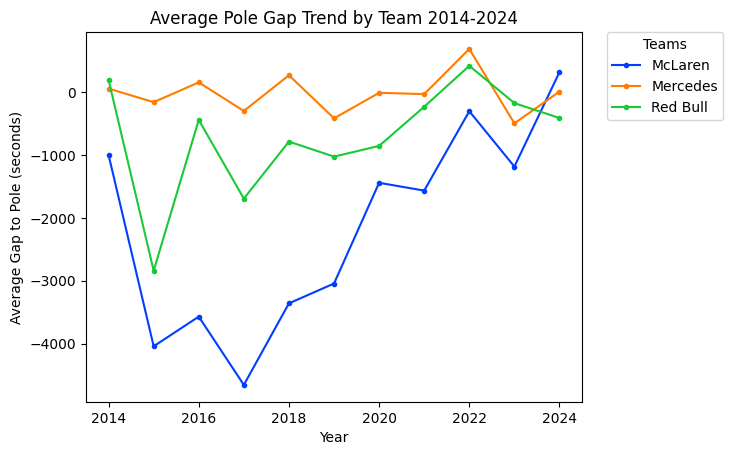

In [ ]:
def calculate_pole_gaps(df):
    pole_times = df[df['GRID'] == 1][['RACEID', 'MILLISECONDS']].rename(
        columns={'MILLISECONDS': 'POLE_TIME'})
    
    gaps = df.merge(pole_times, on='RACEID', how='left')
    gaps['POLE_GAP_SECONDS'] = (gaps['MILLISECONDS'] - gaps['POLE_TIME']) / 1000
    gaps['POLE_GAP_PERCENT'] = (gaps['POLE_GAP_SECONDS'] / (gaps['POLE_TIME']/1000)) * 100
    return gaps

pole_gap = calculate_pole_gaps(df)
for team in key_teams:
    team_data = pole_gap[pole_gap['CONSTRUCTOR_NAME'] == team]
    team_by_year = team_data.groupby('YEAR')['POLE_GAP_SECONDS'].mean().reset_index()
    plt.plot(team_by_year['YEAR'], team_by_year['POLE_GAP_SECONDS'], marker='.', label=team)
plt.title(f'Average Pole Gap Trend by Team {year_boundaries}')
plt.xlabel('Year')
plt.ylabel('Average Gap to Pole (seconds)')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


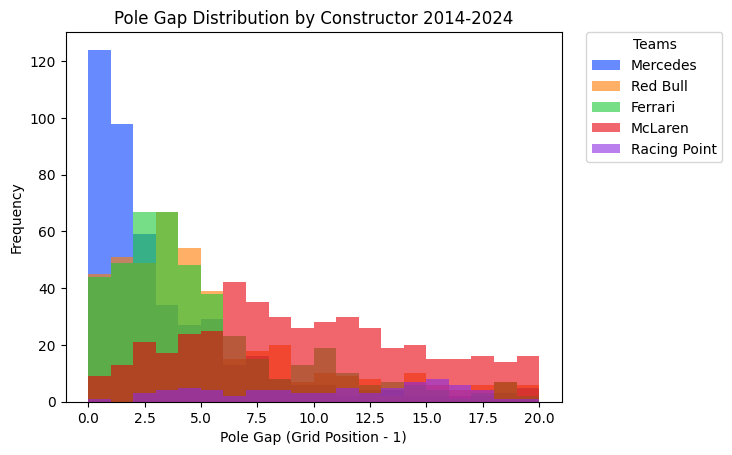

In [ ]:
for i, team in enumerate(top_teams):
    team_data = df[df['CONSTRUCTOR_NAME'] == team]['POLE_GAP']
    plt.hist(team_data, bins=range(0, 21), alpha=0.6, label=team)

plt.title(f'Pole Gap Distribution by Constructor {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Frequency')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

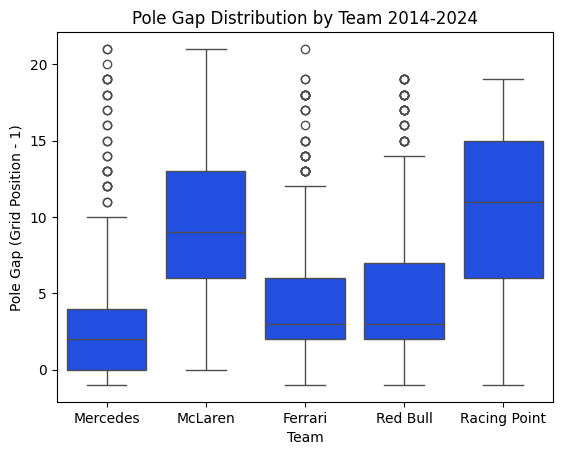

In [ ]:
sns.boxplot(x='CONSTRUCTOR_NAME', y='POLE_GAP', data=df[df['CONSTRUCTOR_NAME'].isin(top_teams)])
plt.title(f'Pole Gap Distribution by Team {year_boundaries}')
plt.xlabel('Team')
plt.ylabel('Pole Gap (Grid Position - 1)')
plt.show()

In [ ]:
print(df.columns)

Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_RACE', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF', 'FASTESTLAPTIME_SEC', 'WIN',
       'POLE_GAP', 'POSITION_CHANGE', 'FASTEST_LAP_GAP', 'CIRCUIT_TYPE',
       'CONTINENT', 'DRIVER_AGE', 'IS_DRIVER_HOME_RACE',
       'IS_CONSTRUCTOR_HOME_RACE', 'PODIUM'],
      dtype='object')


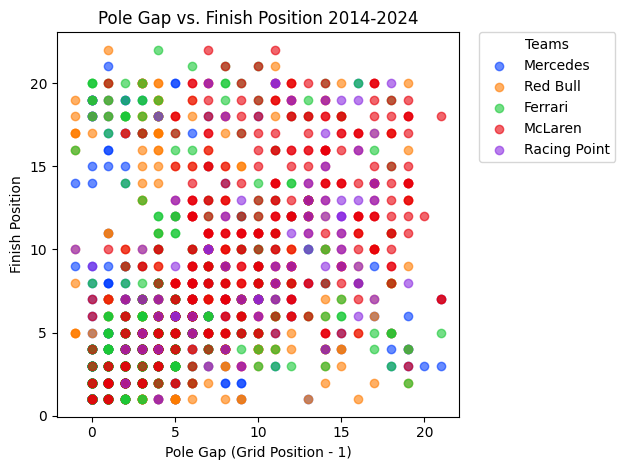

In [ ]:
for team in top_teams:
    team_data = df[df['CONSTRUCTOR_NAME'] == team]
    plt.scatter(team_data['POLE_GAP'], team_data['POSITIONORDER'], alpha=0.6, label=team)

plt.title(f'Pole Gap vs. Finish Position {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Finish Position')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

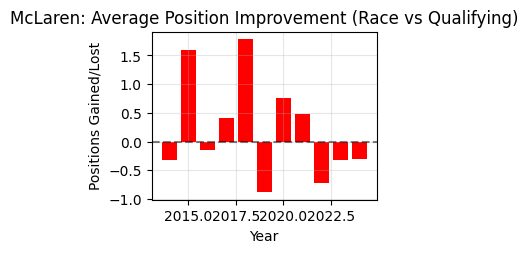

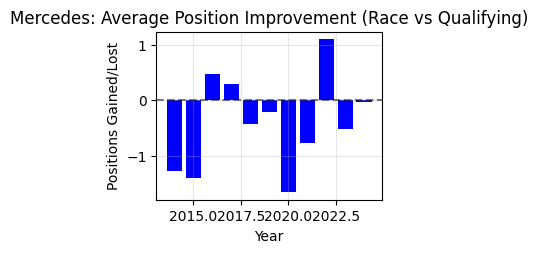

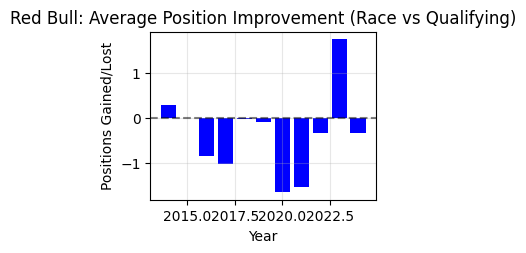

In [ ]:
# Calculate qualifying vs race position improvement
pole_gap['QUALI_RACE_IMPROVEMENT'] = pole_gap['GRID'] - pole_gap['POSITIONORDER']

# Analyze team performance in qualifying vs race
team_quali_race = pole_gap[pole_gap['CONSTRUCTOR_NAME'].isin(key_teams)].groupby(
    ['YEAR', 'CONSTRUCTOR_NAME']).agg({
    'QUALI_RACE_IMPROVEMENT': 'mean',
    'GRID': 'mean',
    'POSITIONORDER': 'mean'
}).reset_index()

# Plot qualifying vs race performance
for i, team in enumerate(key_teams):
    plt.subplot(2, 2, i+1)
    team_data = team_quali_race[team_quali_race['CONSTRUCTOR_NAME'] == team]
    
    plt.bar(team_data['YEAR'], team_data['QUALI_RACE_IMPROVEMENT'], color='red' if team == 'McLaren' else 'blue')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'{team}: Average Position Improvement (Race vs Qualifying)')
    plt.xlabel('Year')
    plt.grid(True, alpha=0.3)
    plt.ylabel('Positions Gained/Lost')
    plt.show()



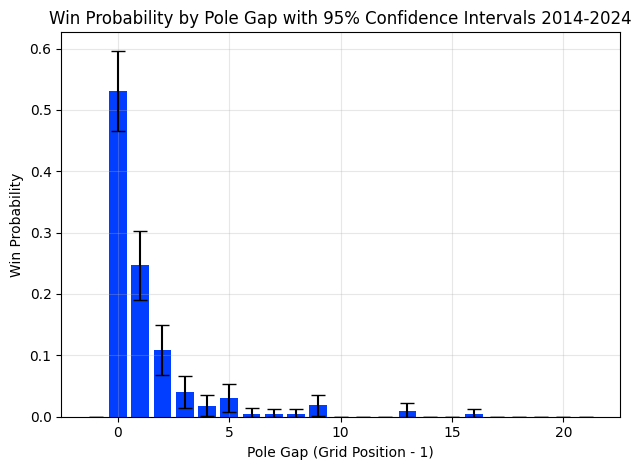

In [ ]:
pole_win_data = df.groupby('POLE_GAP').agg({
    'WIN': ['mean', 'sum', 'count'],
    'PODIUM': 'mean'
}).reset_index()

pole_win_data.columns = ['POLE_GAP', 'WIN_PROB', 'WINS', 'TOTAL', 'PODIUM_PROB']

# Calculate 95% confidence intervals
pole_win_data['WIN_CI_LOW'] = pole_win_data.apply(
    lambda row: max(0, row['WIN_PROB'] - 1.96 * np.sqrt(row['WIN_PROB'] * (1 - row['WIN_PROB']) / row['TOTAL'])), 
    axis=1
)
pole_win_data['WIN_CI_HIGH'] = pole_win_data.apply(
    lambda row: min(1, row['WIN_PROB'] + 1.96 * np.sqrt(row['WIN_PROB'] * (1 - row['WIN_PROB']) / row['TOTAL'])), 
    axis=1
)

pole_win_data = pole_win_data[pole_win_data['TOTAL'] >= 10]

plt.bar(pole_win_data['POLE_GAP'], pole_win_data['WIN_PROB'], yerr=[
    pole_win_data['WIN_PROB'] - pole_win_data['WIN_CI_LOW'],
    pole_win_data['WIN_CI_HIGH'] - pole_win_data['WIN_PROB']
], capsize=5)
plt.title(f'Win Probability by Pole Gap with 95% Confidence Intervals {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Win Probability')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


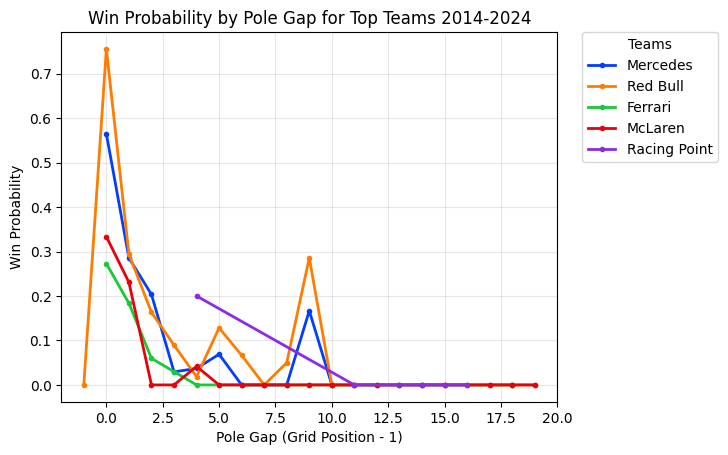

In [ ]:
team_pole_win = df[df['CONSTRUCTOR_NAME'].isin(top_teams)].groupby(
    ['CONSTRUCTOR_NAME', 'POLE_GAP']
).agg({
    'WIN': ['mean', 'count']
}).reset_index()

team_pole_win.columns = ['CONSTRUCTOR_NAME', 'POLE_GAP', 'WIN_PROB', 'COUNT']
team_pole_win = team_pole_win[team_pole_win['COUNT'] >= 5]  # Filter for significance

for team in top_teams:
    team_data = team_pole_win[team_pole_win['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['POLE_GAP'], team_data['WIN_PROB'], marker='.', linewidth=2, label=team)

plt.title(f'Win Probability by Pole Gap for Top Teams {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Win Probability')
plt.grid(True, alpha=0.3)
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

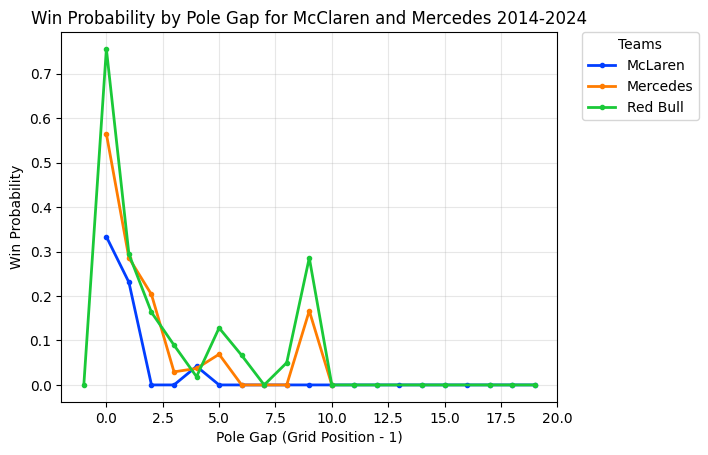

In [ ]:
team_pole_win = df[df['CONSTRUCTOR_NAME'].isin(top_teams)].groupby(
    ['CONSTRUCTOR_NAME', 'POLE_GAP']
).agg({
    'WIN': ['mean', 'count']
}).reset_index()

team_pole_win.columns = ['CONSTRUCTOR_NAME', 'POLE_GAP', 'WIN_PROB', 'COUNT']
team_pole_win = team_pole_win[team_pole_win['COUNT'] >= 5]  # Filter for significance

for team in key_teams:
    team_data = team_pole_win[team_pole_win['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['POLE_GAP'], team_data['WIN_PROB'], marker='.', linewidth=2, label=team)

plt.title(f'Win Probability by Pole Gap for McClaren and Mercedes {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Win Probability')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.show()

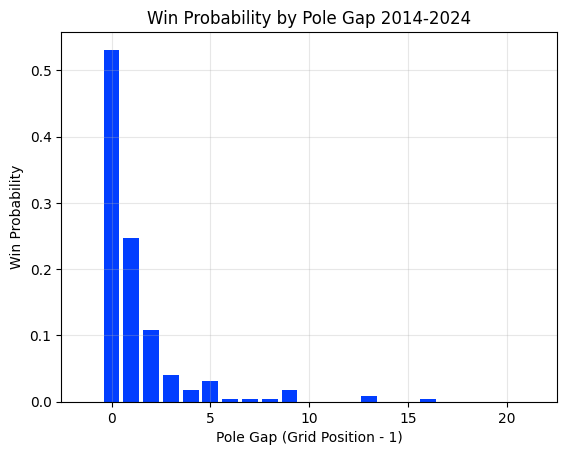

In [ ]:
# Relationship between pole gap and race win probability
pole_win_prob = df.groupby('POLE_GAP')['WIN'].agg(['mean', 'count']).reset_index()
pole_win_prob = pole_win_prob[pole_win_prob['count'] >= 10]  # Filter for statistical significance

plt.bar(pole_win_prob['POLE_GAP'], pole_win_prob['mean'])
plt.title(f'Win Probability by Pole Gap {year_boundaries}')
plt.xlabel('Pole Gap (Grid Position - 1)')
plt.ylabel('Win Probability')
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\2446715178.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



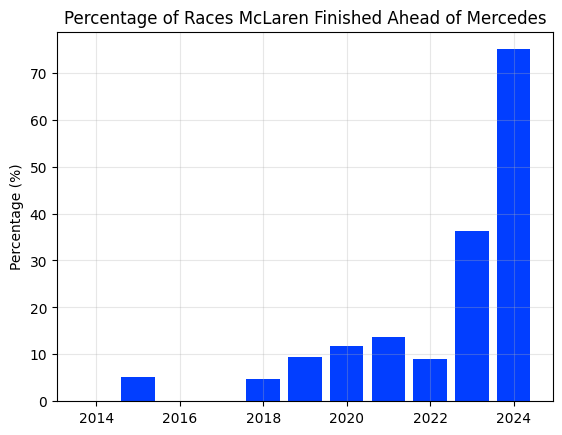

In [ ]:

mclaren_merc = pole_gap[pole_gap['CONSTRUCTOR_NAME'].isin(key_teams)].copy()

head_to_head = mclaren_merc.groupby(['YEAR', 'RACEID']).apply(
    lambda x: pd.Series({
        'McLaren_ahead': x[x['CONSTRUCTOR_NAME'] == 'McLaren']['POSITIONORDER'].min() < 
                        x[x['CONSTRUCTOR_NAME'] == 'Mercedes']['POSITIONORDER'].min(),
        'McLaren_pole_gap': x[x['CONSTRUCTOR_NAME'] == 'McLaren']['POLE_GAP_SECONDS'].mean(),
        'Mercedes_pole_gap': x[x['CONSTRUCTOR_NAME'] == 'Mercedes']['POLE_GAP_SECONDS'].mean(),
        'Pole_gap_diff': x[x['CONSTRUCTOR_NAME'] == 'McLaren']['POLE_GAP_SECONDS'].mean() - 
                        x[x['CONSTRUCTOR_NAME'] == 'Mercedes']['POLE_GAP_SECONDS'].mean()
    })
).reset_index()

yearly_comparison = head_to_head.groupby('YEAR').agg({
    'McLaren_ahead': 'mean',
    'McLaren_pole_gap': 'mean',
    'Mercedes_pole_gap': 'mean',
    'Pole_gap_diff': 'mean'
}).reset_index()

plt.bar(yearly_comparison['YEAR'], yearly_comparison['McLaren_ahead'] * 100)
plt.title('Percentage of Races McLaren Finished Ahead of Mercedes')
plt.ylabel('Percentage (%)')
plt.grid(True, alpha=0.3)
plt.show()

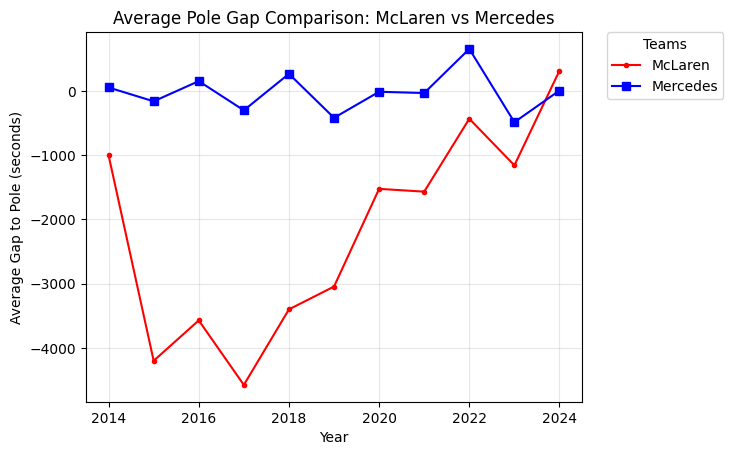

In [ ]:
plt.plot(yearly_comparison['YEAR'], yearly_comparison['McLaren_pole_gap'], marker='.', label='McLaren', color='red')
plt.plot(yearly_comparison['YEAR'], yearly_comparison['Mercedes_pole_gap'], marker='s', label='Mercedes', color='blue')
plt.title('Average Pole Gap Comparison: McLaren vs Mercedes')
plt.xlabel('Year')
plt.ylabel('Average Gap to Pole (seconds)')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.show()

#### Circuit Location Analysis


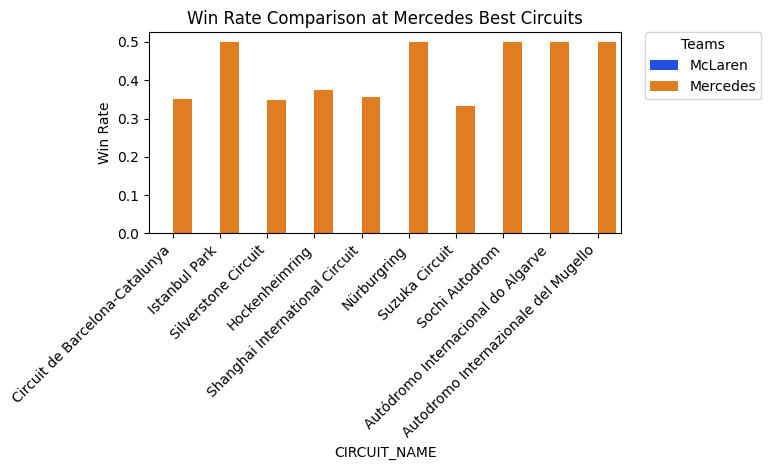

In [ ]:
# perf by circuit

circuit_performance = df.groupby(['CIRCUITID', 'CONSTRUCTOR_NAME']).agg({
    'WIN': 'mean',
    'PODIUM': 'sum',
    'POINTS': 'mean',
    'DNF': 'mean',
    'RESULTID': 'count'
}).reset_index()
circuit_performance['PODIUM_RATE'] = circuit_performance['PODIUM'] / circuit_performance['RESULTID']
circuit_performance = circuit_performance.sort_values(['CONSTRUCTOR_NAME', 'WIN'], ascending=[True, False])

circuit_performance = circuit_performance.merge(
    circuits[['CIRCUITID', 'NAME']],  # Only bring in the necessary column
    on='CIRCUITID',
    how='left'
)
circuit_performance.rename(columns={'NAME': 'CIRCUIT_NAME'}, inplace=True)

filtered = circuit_performance[circuit_performance['CONSTRUCTOR_NAME'].isin(['Mercedes', 'McLaren'])]
win_gap = filtered.pivot_table(index='CIRCUIT_NAME', columns='CONSTRUCTOR_NAME', values='WIN')
win_gap['WIN_GAP'] = win_gap['Mercedes'] - win_gap['McLaren']
top_circuits = win_gap['WIN_GAP'].sort_values(ascending=False).head(10).index.tolist()
top_data = filtered[filtered['CIRCUIT_NAME'].isin(top_circuits)]


sns.barplot(data=top_data, x='CIRCUIT_NAME', y='WIN', hue='CONSTRUCTOR_NAME')
plt.title('Win Rate Comparison at Mercedes Best Circuits')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\4090584212.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



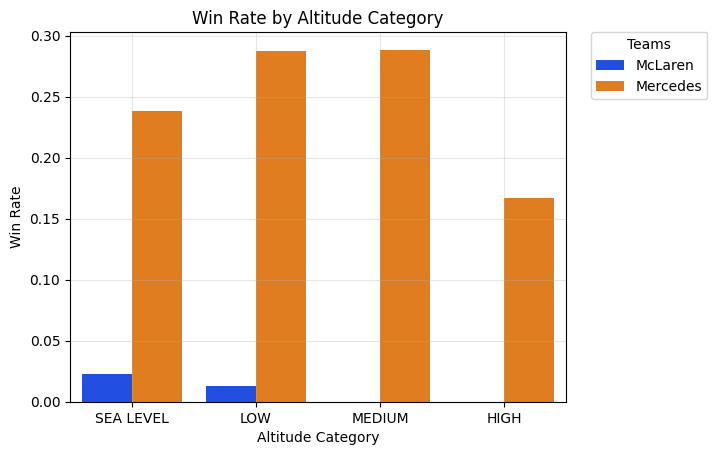

In [ ]:
# PERF BY ALT

altitude_performance = df.groupby(['ALTITUDE_CATEGORY', 'CONSTRUCTOR_NAME']).agg({
    'WIN': 'mean',
    'PODIUM': 'sum',
    'POINTS': 'mean',
    'DNF': 'mean',
    'RESULTID': 'count'
}).reset_index()

altitude_performance = altitude_performance[altitude_performance['CONSTRUCTOR_NAME'].isin(['Mercedes', 'McLaren'])]

sns.barplot(
    data=altitude_performance,
    x='ALTITUDE_CATEGORY',
    y='WIN',
    hue='CONSTRUCTOR_NAME'
)
plt.title('Win Rate by Altitude Category')
plt.xlabel('Altitude Category')
plt.ylabel('Win Rate')
plt.grid(True, alpha=0.3)
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
dnf_by_circuit = df.groupby('CIRCUITID').agg(
    total_entries=('DNF', 'count'),
    total_dnfs=('DNF', 'sum'),
    total_races=('RACEID', pd.Series.nunique)
).reset_index()

def get_dnf_by_circuit(dnf_by_circuit):
    
    dnf_by_circuit['total_finishes'] = dnf_by_circuit['total_entries'] - dnf_by_circuit['total_dnfs']
    dnf_by_circuit['dnf_rate'] = dnf_by_circuit['total_dnfs'] / dnf_by_circuit['total_entries']
    circuit_info = df[['CIRCUITID', 'NAME', 'ALTITUDE_CATEGORY']].drop_duplicates(subset='CIRCUITID')
    dnf_by_circuit = dnf_by_circuit.merge(circuit_info, on='CIRCUITID', how='left')

    dnf_by_circuit_all = dnf_by_circuit[dnf_by_circuit['total_races'] >= 4].copy()
    dnf_by_circuit_all = dnf_by_circuit_all.sort_values('dnf_rate', ascending=False).head(10)
    dnf_by_circuit_all = dnf_by_circuit_all[['CIRCUITID', 'NAME', 'total_entries', 'total_races',
                                    'total_dnfs', 'total_finishes', 'dnf_rate', 'ALTITUDE_CATEGORY']]
    return dnf_by_circuit_all
dnf_by_circuit_all = get_dnf_by_circuit(dnf_by_circuit)
print(dnf_by_circuit_all.head(10))

    CIRCUITID                            NAME  total_entries  total_races  \
0           1  Albert Park Grand Prix Circuit            172            9   
25         73               Baku City Circuit            160            8   
8          10                  Hockenheimring             83            4   
22         69         Circuit of the Americas            199           10   
1           2    Sepang International Circuit             80            4   
28         77         Jeddah Corniche Circuit             78            4   
12         15       Marina Bay Street Circuit            175            9   
6           7       Circuit Gilles Villeneuve            178            9   
5           6               Circuit de Monaco            197           10   
23         70                   Red Bull Ring            260           13   

    total_dnfs  total_finishes  dnf_rate ALTITUDE_CATEGORY  
0           41             131  0.238372         SEA LEVEL  
25          35             125

In [ ]:
for team in key_teams:
    team_df = df[df['CONSTRUCTOR_NAME'] == team].copy()
    dnf_by_team_circuit = team_df.groupby('CIRCUITID').agg(
    total_entries=('DNF', pd.Series.count),
    total_dnfs=('DNF', pd.Series.sum),
    total_races=('RACEID', pd.Series.nunique)).reset_index()
    dnf_by_team_circuit = get_dnf_by_circuit(dnf_by_team_circuit)
    print(f'Top 10 Difficult Circuits for {team}')
    print(dnf_by_team_circuit)

Top 10 Difficult Circuits for McLaren
    CIRCUITID                            NAME  total_entries  total_races  \
6           7       Circuit Gilles Villeneuve             18            9   
12         15       Marina Bay Street Circuit             18            9   
2           3   Bahrain International Circuit             22           12   
1           2    Sepang International Circuit              8            4   
8          10                  Hockenheimring              8            4   
11         14    Autodromo Nazionale di Monza             22           11   
3           4  Circuit de Barcelona-Catalunya             22           11   
13         17  Shanghai International Circuit             14            7   
10         13    Circuit de Spa-Francorchamps             19           11   
5           6               Circuit de Monaco             20           10   

    total_dnfs  total_finishes  dnf_rate ALTITUDE_CATEGORY  
6            6              12  0.333333         SEA 

Top 10 Difficult Circuits for Mercedes
    CIRCUITID                            NAME  total_entries  total_races  \
0           1  Albert Park Grand Prix Circuit             18            9   
12         15       Marina Bay Street Circuit             18            9   
1           2    Sepang International Circuit              8            4   
16         21   Autodromo Enzo e Dino Ferrari              8            4   
8          10                  Hockenheimring              8            4   
6           7       Circuit Gilles Villeneuve             18            9   
14         18      Autódromo José Carlos Pace             20           10   
22         69         Circuit of the Americas             20           10   
10         13    Circuit de Spa-Francorchamps             21           11   
7           9             Silverstone Circuit             23           12   

    total_dnfs  total_finishes  dnf_rate ALTITUDE_CATEGORY  
0            4              14  0.222222         SEA

In [ ]:
# top dnf reasons per team

#### Tire Strategy/ Pit Stop Analysis


In [ ]:
#  load data, but pitstops has pre 2014 so need to sort that out
pit_stops = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.PIT_STOPS')
pit_stops['DURATION'] = pd.to_numeric(pit_stops['DURATION'], errors='coerce')
first_raceid = df['RACEID'].min()
recent_pit_stops = pit_stops[pit_stops['RACEID'] >= first_raceid].copy()
circuit_constructor_info = df[['RACEID', 'DRIVERID', 'CIRCUITID', 'CONSTRUCTOR_NAME', 'RACE_NAME', 'YEAR', 'NAME', 'GRID']].copy()
circuit_constructor_info.rename(columns={'NAME': 'CIRCUIT_NAME'}, inplace=True)

pit_analysis = recent_pit_stops.merge(
    circuit_constructor_info,
    on=['RACEID', 'DRIVERID'],
    how='inner'
)

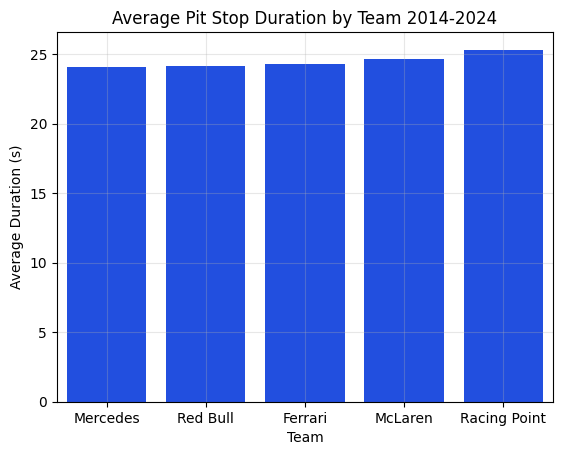

In [ ]:
# # Define top teams for comparison
top_teams_pit = pit_analysis[pit_analysis['CONSTRUCTOR_NAME'].isin(top_teams)].copy()

avg_durations = top_teams_pit.groupby('CONSTRUCTOR_NAME')['DURATION'].mean().loc[top_teams]


sns.barplot(x=avg_durations.index, y=avg_durations.values)
plt.title(f'Average Pit Stop Duration by Team {year_boundaries}')
plt.ylabel('Average Duration (s)')
plt.xlabel('Team')
plt.grid(True, alpha=0.3)
plt.show()

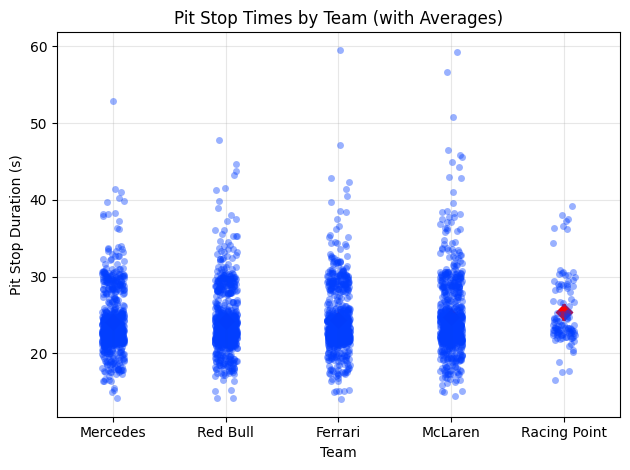

In [ ]:
sns.pointplot(x='CONSTRUCTOR_NAME', y='DURATION', data=top_teams_pit, order=top_teams, color='red', linestyle='none', markers='D')
sns.stripplot(x='CONSTRUCTOR_NAME', y='DURATION', data=top_teams_pit, order=top_teams, alpha=0.4, jitter=True)
plt.title('Pit Stop Times by Team (with Averages)')
plt.xlabel('Team')
plt.ylabel('Pit Stop Duration (s)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

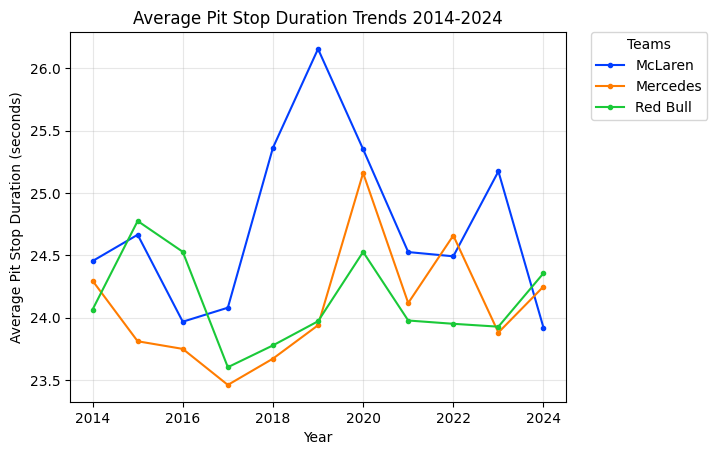

In [ ]:
yearly_pit_times = pit_analysis.groupby(['YEAR', 'CONSTRUCTOR_NAME'])['DURATION'].mean().reset_index()

for team in key_teams:
    team_data = yearly_pit_times[yearly_pit_times['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DURATION'], marker='.', label=team)

plt.title(f'Average Pit Stop Duration Trends {year_boundaries}')
plt.xlabel('Year')
plt.ylabel('Average Pit Stop Duration (seconds)')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.show()

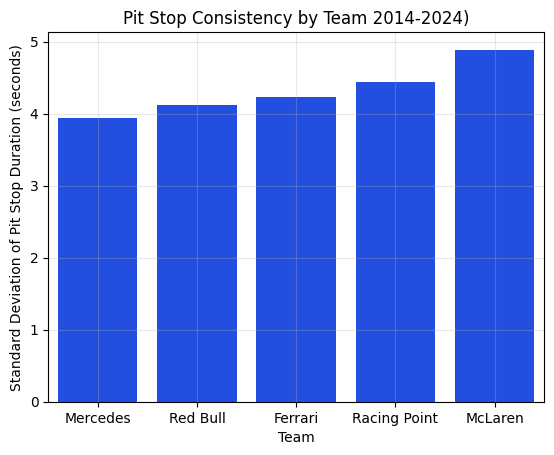

In [ ]:
pit_consistency = top_teams_pit.groupby('CONSTRUCTOR_NAME')['DURATION'].agg(['mean', 'std', 'count']).reset_index()
pit_consistency['cv'] = pit_consistency['std'] / pit_consistency['mean']  # Coefficient of variation
pit_consistency = pit_consistency.sort_values('std')

sns.barplot(x='CONSTRUCTOR_NAME', y='std', data=pit_consistency)
plt.title(f'Pit Stop Consistency by Team {year_boundaries})')
plt.xlabel('Team')
plt.ylabel('Standard Deviation of Pit Stop Duration (seconds)')
plt.grid(True, alpha=0.3)
plt.show()

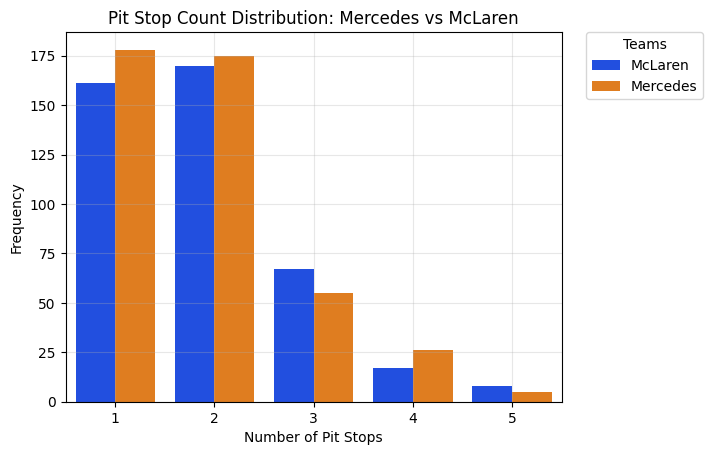

In [ ]:
# 4. Pit Stop Count Distribution
pit_count = top_teams_pit.groupby(['RACEID', 'DRIVERID', 'CONSTRUCTOR_NAME']).size().reset_index(name='PIT_STOPS')
pit_count_dist = pit_count.groupby(['CONSTRUCTOR_NAME', 'PIT_STOPS']).size().reset_index(name='FREQUENCY')
pit_count_dist = pit_count_dist[pit_count_dist['CONSTRUCTOR_NAME'].isin(['Mercedes', 'McLaren'])]

sns.barplot(x='PIT_STOPS', y='FREQUENCY', hue='CONSTRUCTOR_NAME', 
            data=pit_count_dist[pit_count_dist['PIT_STOPS'] <= 5])
plt.title('Pit Stop Count Distribution: Mercedes vs McLaren')
plt.xlabel('Number of Pit Stops')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

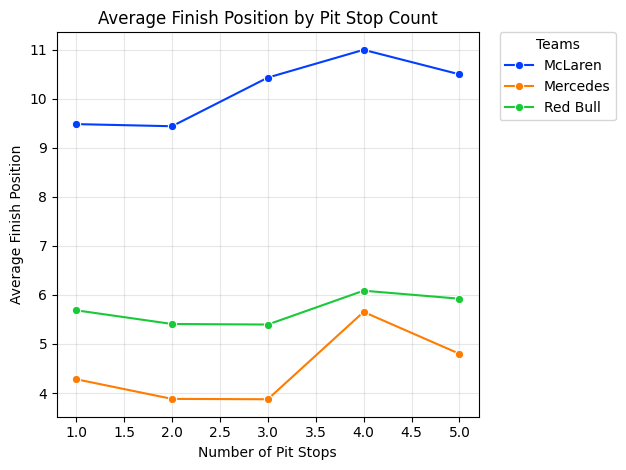

In [ ]:
pit_results = pit_count.merge(
    df[['RACEID', 'DRIVERID', 'CONSTRUCTOR_NAME', 'POSITIONORDER', 'POINTS', 'WIN']], 
    on=['RACEID', 'DRIVERID', 'CONSTRUCTOR_NAME'],
    how='inner'
)

# # calc average finish position by pit stop count
pit_finish = pit_results.groupby(['CONSTRUCTOR_NAME', 'PIT_STOPS'])['POSITIONORDER'].mean().reset_index()
pit_finish = pit_finish[pit_finish['CONSTRUCTOR_NAME'].isin(key_teams)]

sns.lineplot(x='PIT_STOPS', y='POSITIONORDER', hue='CONSTRUCTOR_NAME', 
             data=pit_finish[pit_finish['PIT_STOPS'] <= 5], 
             marker='o')
plt.title('Average Finish Position by Pit Stop Count')
plt.xlabel('Number of Pit Stops')
plt.ylabel('Average Finish Position')
plt.grid(True, alpha=0.3)
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

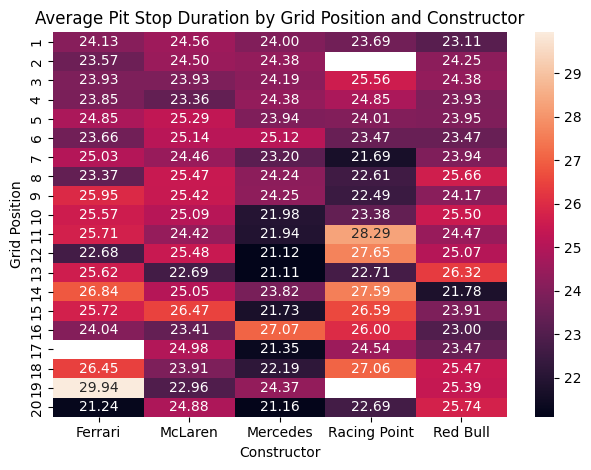

In [ ]:
pivot = top_teams_pit.pivot_table(
    values='DURATION',
    index='GRID',
    columns='CONSTRUCTOR_NAME',
    aggfunc='mean'
).loc[1:20]  # limit to normal grid positions
sns.heatmap(pivot, annot=True, fmt='.2f')
plt.title('Average Pit Stop Duration by Grid Position and Constructor')
plt.xlabel('Constructor')
plt.ylabel('Grid Position')
plt.tight_layout()
plt.show()


In [ ]:
team_pit_stats = top_teams_pit.groupby('CONSTRUCTOR_NAME').agg({
    'DURATION': ['mean', 'median', 'std', 'min', 'count']
}).reset_index()

team_pit_stats.columns = ['CONSTRUCTOR_NAME', 'AVG_DURATION', 'MEDIAN_DURATION', 
                         'STD_DURATION', 'MIN_DURATION', 'PIT_COUNT']

print('Pit Stop Performance Summary:')
print(team_pit_stats.sort_values('AVG_DURATION'))

# Calculate points per pit stop
team_points = pit_results.groupby('CONSTRUCTOR_NAME').agg({
    'POINTS': 'sum',
    'PIT_STOPS': 'sum'
}).reset_index()

team_points['POINTS_PER_PIT'] = team_points['POINTS'] / team_points['PIT_STOPS']
print('Points per Pit Stop:')
print(team_points.sort_values('POINTS_PER_PIT', ascending=False))


Pit Stop Performance Summary:
  CONSTRUCTOR_NAME  AVG_DURATION  MEDIAN_DURATION  STD_DURATION  MIN_DURATION  \
2         Mercedes     24.089914           23.277      3.944050        14.155   
4         Red Bull     24.156423           23.231      4.115670        14.113   
0          Ferrari     24.320652           23.414      4.226278        14.008   
1          McLaren     24.681649           23.686      4.888655        14.493   
3     Racing Point     25.317126           23.650      4.443895        16.546   

   PIT_COUNT  
2        787  
4        799  
0        755  
1        769  
3        111  
Points per Pit Stop:
  CONSTRUCTOR_NAME  POINTS  PIT_STOPS  POINTS_PER_PIT
2         Mercedes  6703.0        841        7.970273
4         Red Bull  5200.0        848        6.132075
0          Ferrari  4567.0        801        5.701623
1          McLaren  2016.0        822        2.452555
3     Racing Point   283.0        118        2.398305


#### Driver Analysis


Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_RACE', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF', 'FASTESTLAPTIME_SEC', 'WIN',
       'POLE_GAP', 'POSITION_CHANGE', 'FASTEST_LAP_GAP', 'CIRCUIT_TYPE',
       'CONTINENT', 'DRIVER_AGE', 'IS_DRIVER_HOME_RACE',
       'IS_CONSTRUCTOR_HOME_RACE', 'PODIUM'],
      dtype='object')
  CONSTRUCTOR_NAME           FULL_NAME  POINTS
2       Alfa Romeo      Kimi Räikkönen    57.0
4       Alfa Romeo     Valtteri Bottas    57.0
0       Alfa Romeo  Antonio Giovinazzi    21.0
1       Alfa Romeo         Guanyu 

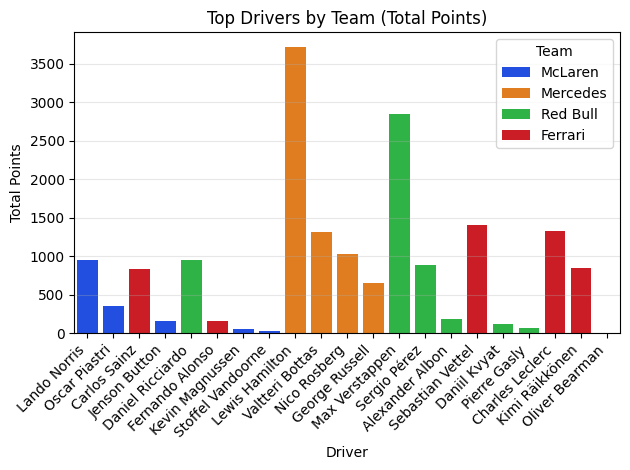

In [ ]:
print(df.columns)
top_drivers = df.groupby(['CONSTRUCTOR_NAME', 'FULL_NAME'])['POINTS'].sum().reset_index()
top_drivers = top_drivers.sort_values(['CONSTRUCTOR_NAME', 'POINTS'], ascending=[True, False])
print(top_drivers.head())

top_team_drivers = []
new_key_teams = key_teams.append('Ferrari')
for team in key_teams:
    team_drivers = top_drivers[top_drivers['CONSTRUCTOR_NAME'] == team]
    top_team_drivers.append(team_drivers)

top_team_drivers = pd.concat(top_team_drivers)

sns.barplot(data=top_team_drivers, x='FULL_NAME', y='POINTS', hue='CONSTRUCTOR_NAME', 
        palette='bright', dodge=False)

plt.title('Top Drivers by Team (Total Points)')
plt.xlabel('Driver')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.legend(title='Team')
plt.tight_layout()
plt.show()


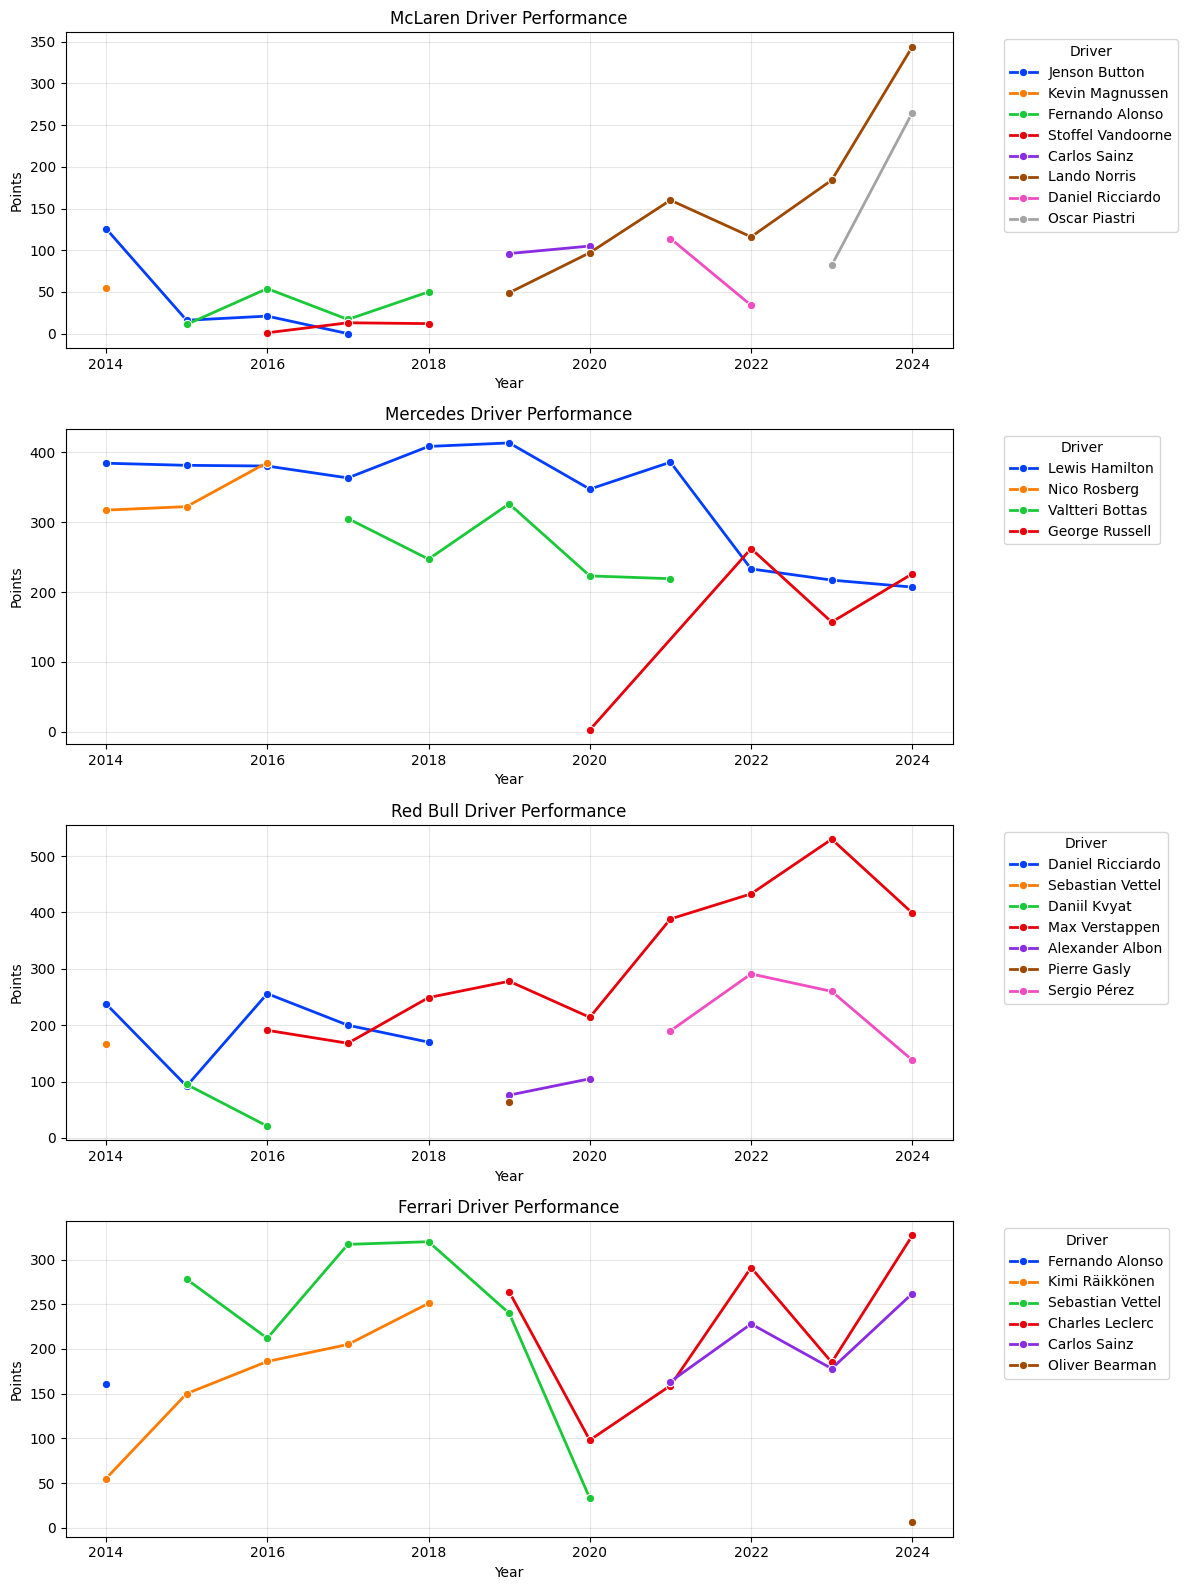

In [ ]:
driver_yearly = df.groupby(['YEAR', 'CONSTRUCTOR_NAME', 'FULL_NAME'])['POINTS'].sum().reset_index()

# Create a figure with subplots for each team
fig, axes = plt.subplots(len(key_teams), 1, figsize=(12, 4*len(key_teams)))

# Plot each team
for i, team in enumerate(key_teams):
    team_data = driver_yearly[driver_yearly['CONSTRUCTOR_NAME'] == team]
    
    # Create line plot
    sns.lineplot(data=team_data, x='YEAR', y='POINTS', hue='FULL_NAME', 
                 marker='o', linewidth=2, ax=axes[i])
    
    axes[i].set_title(f'{team} Driver Performance')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Points')
    axes[i].grid(True, alpha=0.3)
    
    # Adjust legend
    axes[i].legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Yearly perf
yearly_perf_driver = df.groupby(['YEAR', 'DRIVERID', 'FULL_NAME']).agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': lambda x: sum(pd.to_numeric(x, errors='coerce')),
    'RESULTID': 'count',
    'DNF': 'sum'
}).reset_index()

yearly_perf_driver['WIN_RATE'] = yearly_perf_driver['WIN'] / yearly_perf_driver['RESULTID']
yearly_perf_driver['PODIUM_RATE'] = yearly_perf_driver['PODIUM'] / yearly_perf_driver['RESULTID']
yearly_perf_driver['AVG_POINTS'] = yearly_perf_driver['POINTS'] / yearly_perf_driver['RESULTID']
yearly_perf_driver['DNF_RATE'] = yearly_perf_driver['DNF'] / yearly_perf_driver['RESULTID']
driver_performance = df.groupby('DRIVERID').agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': 'sum',
    'DNF': 'sum',
    'RESULTID': 'count',
    'GRID': 'mean',
    'POSITIONORDER': 'mean',
    'FASTESTLAP': lambda x: (x == 1).sum()
}).reset_index()

driver_performance = driver_performance.merge(df[['DRIVERID','FULL_NAME']].drop_duplicates(subset='DRIVERID'), on='DRIVERID', how='left')

driver_performance['WIN_RATE'] = driver_performance['WIN'] / driver_performance['RESULTID']
driver_performance['PODIUM_RATE'] = driver_performance['PODIUM'] / driver_performance['RESULTID']
driver_performance['DNF_RATE'] = driver_performance['DNF'] / driver_performance['RESULTID']
driver_performance['AVG_POINTS'] = driver_performance['POINTS'] / driver_performance['RESULTID']
driver_performance['GRID_TO_FINISH'] = driver_performance['GRID'] - driver_performance['POSITIONORDER']
driver_performance['FASTEST_LAP_RATE'] = driver_performance['FASTESTLAP'] / driver_performance['RESULTID']

driver_performance = driver_performance.sort_values('WIN_RATE', ascending=False)
print(f'Driver Performance Overview {year_boundaries}:')
print(driver_performance[['DRIVERID', 'FULL_NAME', 'WIN', 'WIN_RATE', 'PODIUM', 'PODIUM_RATE', 'AVG_POINTS', 'DNF_RATE', 'FASTEST_LAP_RATE', 'GRID_TO_FINISH']])



Driver Performance Overview 2014-2024:
    DRIVERID           FULL_NAME  WIN  WIN_RATE  PODIUM  PODIUM_RATE  \
0          1      Lewis Hamilton   83  0.370536     148     0.660714   
1          3        Nico Rosberg   20  0.344828      46     0.793103   
26       830      Max Verstappen   63  0.310345     112     0.551724   
8         20    Sebastian Vettel   14  0.079545      60     0.340909   
40       844     Charles Leclerc    8  0.056338      43     0.302817   
53       857       Oscar Piastri    2  0.044444      10     0.222222   
19       822     Valtteri Bottas   10  0.044248      67     0.296460   
15       817    Daniel Ricciardo    8  0.039216      32     0.156863   
42       846        Lando Norris    4  0.031250      26     0.203125   
14       815        Sergio Pérez    6  0.027149      36     0.162896   
43       847      George Russell    3  0.023622      15     0.118110   
28       832        Carlos Sainz    4  0.020101      27     0.135678   
35       839        Esteb

['Lewis Hamilton', 'Nico Rosberg', 'Max Verstappen', 'Sebastian Vettel', 'Charles Leclerc']


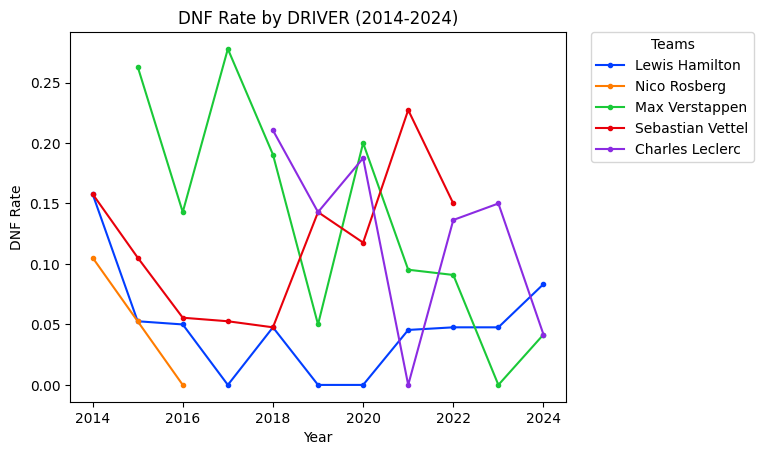

In [ ]:
top_driver = driver_performance.sort_values('WIN_RATE', ascending=False).head(5)['FULL_NAME'].tolist()
print(top_driver)
for team in top_driver:
    team_data = yearly_perf_driver[yearly_perf_driver['FULL_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DNF_RATE'], marker='.',label=team)

plt.title(f'DNF Rate by DRIVER ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('DNF Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [ ]:

print(df.columns)
# Filter for key drivers
key_driver_results = df[df['FULL_NAME'].isin(top_driver)].copy()

# Calculate DNF rate by driver
driver_dnf_rates = key_driver_results.groupby('FULL_NAME')['DNF'].agg(['sum', 'count'])
driver_dnf_rates['rate'] = driver_dnf_rates['sum'] / driver_dnf_rates['count'] * 100
driver_dnf_rates = driver_dnf_rates.sort_values('rate')

# Display DNF rates
driver_dnf_rates

Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_RACE', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF', 'FASTESTLAPTIME_SEC', 'WIN',
       'POLE_GAP', 'POSITION_CHANGE', 'FASTEST_LAP_GAP', 'CIRCUIT_TYPE',
       'CONTINENT', 'DRIVER_AGE', 'IS_DRIVER_HOME_RACE',
       'IS_CONSTRUCTOR_HOME_RACE', 'PODIUM'],
      dtype='object')


,sum,count,rate
FULL_NAME,,,
Lewis Hamilton,11,224,4.910714
Nico Rosberg,3,58,5.172414
Sebastian Vettel,21,176,11.931818
Charles Leclerc,17,142,11.971831
Max Verstappen,26,203,12.807882


In [ ]:
dnf_results = key_driver_results[key_driver_results['DNF']].copy()

# Group DNF reasons by driver
driver_dnf_reasons = dnf_results.groupby(['FULL_NAME', 'STATUS']).size().reset_index(name='count')

# Sort by count within each driver
driver_dnf_reasons = driver_dnf_reasons.sort_values(['FULL_NAME', 'count'], ascending=[True, False])

# Display top DNF reasons by driver
for driver in top_driver:
    print(f'\n{driver} - Top DNF reasons:')
    driver_reasons = driver_dnf_reasons[driver_dnf_reasons['FULL_NAME'] == driver].head(5)
    print(driver_reasons[['STATUS', 'count']])


Lewis Hamilton - Top DNF reasons:
           STATUS  count
14         Engine      3
11         Brakes      1
12      Collision      1
13   Disqualified      1
15  Fuel pressure      1

Nico Rosberg - Top DNF reasons:
        STATUS  count
36  Electrical      1
37     Gearbox      1
38    Throttle      1

Max Verstappen - Top DNF reasons:
        STATUS  count
21      Brakes      4
20    Accident      3
22   Collision      2
24  Electrical      2
26      Engine      2

Sebastian Vettel - Top DNF reasons:
              STATUS  count
39          Accident      3
41         Collision      3
42  Collision damage      2
45            Engine      2
52              Tyre      2

Charles Leclerc - Top DNF reasons:
             STATUS  count
0          Accident      3
1         Collision      3
2  Collision damage      2
5            Engine      2
3      Disqualified      1


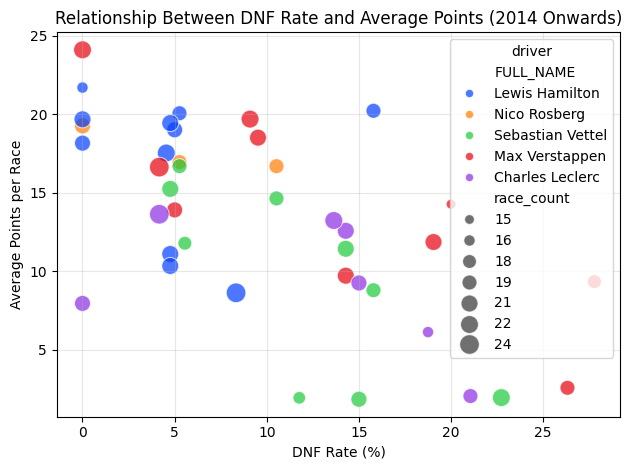

In [ ]:

driver_yearly = key_driver_results.groupby(['YEAR', 'FULL_NAME']).agg(
    total_points=('POINTS', 'sum'),
    dnf_count=('DNF', 'sum'),
    race_count=('DNF', 'count')
).reset_index()

driver_yearly['dnf_rate'] = driver_yearly['dnf_count'] / driver_yearly['race_count'] * 100
driver_yearly['avg_points_per_race'] = driver_yearly['total_points'] / driver_yearly['race_count']

sns.scatterplot(data=driver_yearly, x='dnf_rate', y='avg_points_per_race', 
                hue='FULL_NAME', size='race_count', sizes=(50, 200), alpha=0.7)

plt.title('Relationship Between DNF Rate and Average Points (2014 Onwards)')
plt.xlabel('DNF Rate (%)')
plt.ylabel('Average Points per Race')
plt.grid(True, alpha=0.3)
plt.legend(title='driver')
plt.tight_layout()
plt.show()

Driver Age by Team:
  CONSTRUCTOR_NAME       mean        min        max
3     Racing Point  25.806094  20.380561  33.147159
4         Red Bull  26.083751  18.622861  34.847365
1          McLaren  27.880583  19.340178  37.355236
0          Ferrari  29.864882  18.836413  39.107461
2         Mercedes  31.654276  22.806297  39.917864
Performance by Driver Age Group:
  AGE_GROUP  WIN_RATE  PODIUM_RATE  AVG_POINTS  DNF_RATE  RACE_COUNT
0  (15, 25]  0.028644     0.101209    3.803628  0.152769        1571
1  (25, 30]  0.051852     0.155556    5.378114  0.150842        1485
2  (30, 35]  0.093333     0.231111    6.975556  0.138889         900
3  (35, 40]  0.053790     0.188264    6.165037  0.141809         409
4  (40, 45]  0.000000     0.074380    3.553719  0.115702         121


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\3313232474.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



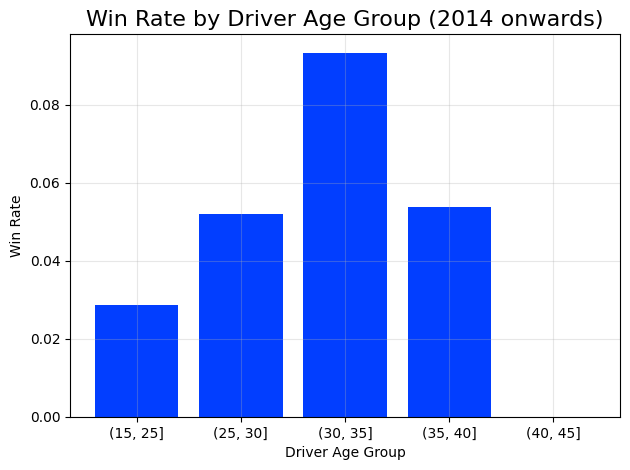

In [ ]:

age_by_team = df[df['CONSTRUCTOR_NAME'].isin(top_teams)].groupby('CONSTRUCTOR_NAME')['DRIVER_AGE'].agg(['mean', 'min', 'max']).reset_index()
print('Driver Age by Team:')
print(age_by_team.sort_values('mean'))


age_performance = df.groupby(pd.cut(df['DRIVER_AGE'], bins=[15, 25, 30, 35, 40, 45])).agg({
    'WIN': 'mean',
    'PODIUM': 'mean',
    'POINTS': 'mean',
    'DNF': 'mean',
    'RESULTID': 'count'
}).reset_index()
age_performance.columns = ['AGE_GROUP', 'WIN_RATE', 'PODIUM_RATE', 'AVG_POINTS', 'DNF_RATE', 'RACE_COUNT']

print('Performance by Driver Age Group:')
print(age_performance)

plt.bar(age_performance['AGE_GROUP'].astype(str), age_performance['WIN_RATE'])
plt.title('Win Rate by Driver Age Group (2014 onwards)', fontsize=16)
plt.xlabel('Driver Age Group')
plt.ylabel('Win Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Lap Time Analysis


In [ ]:
# lap time analysis for top teams
# visualise distribution
# relationship between fastest lap and race win

### Factor Analysis using Machine Learning


#### Prepare Data for Modelling


                    Missing Values  Percent Missing
FASTESTLAPTIME                  80         1.783326
FASTEST_LAP_GAP                 80         1.783326
FASTESTLAPTIME_SEC              80         1.783326
FASTESTLAP                      71         1.582702
FASTESTLAPSPEED                 71         1.582702


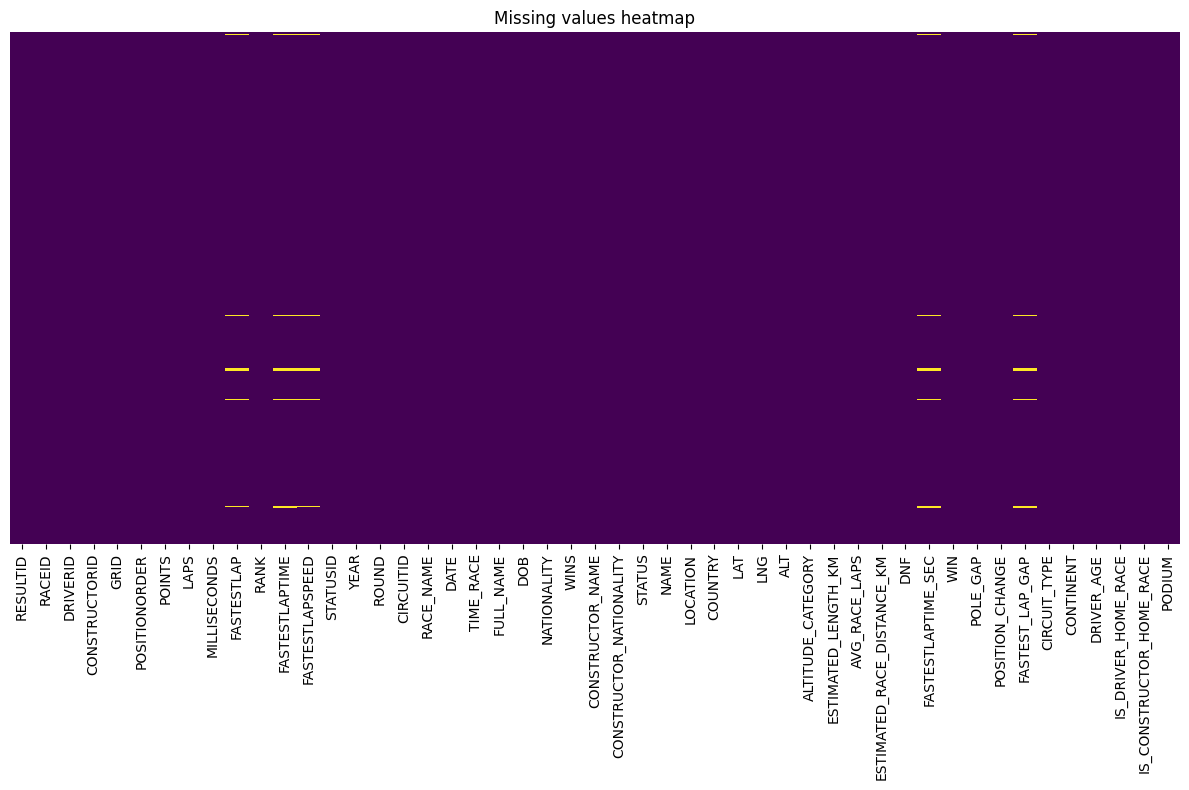

In [ ]:
missing_vals_analysis(df)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
def prepare_data_for_modeling(df):
    mdf = df.copy()
    num_cols = ['FASTESTLAP', 'FASTESTLAPTIME_SEC', 'FASTEST_LAP_GAP', 'FASTESTLAPSPEED']
    mdf[num_cols] = SimpleImputer(strategy='median').fit_transform(mdf[num_cols].fillna(0))

    mdf['IS_MERCEDES'] = (mdf['CONSTRUCTORID'] == 131).astype(int)
    mdf['IS_REDBULL'] = (mdf['CONSTRUCTORID'] == 9).astype(int)
    mdf['IS_MCLAREN'] = (mdf['CONSTRUCTORID'] == 1).astype(int)
    mdf['GRID_ADVANTAGE'] = mdf.groupby('RACEID')['GRID'].transform('min') - mdf['GRID']
    mdf['POSITION_CHANGE'] = mdf['GRID'] - mdf['POSITIONORDER']

    cat_cols = ['NATIONALITY', 'CONSTRUCTOR_NATIONALITY', 'COUNTRY', 'ALTITUDE_CATEGORY', 'CONTINENT', 'CIRCUIT_TYPE']
    mdf[cat_cols] = mdf[cat_cols].apply(lambda col: col.str.upper())
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(mdf[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=mdf.index)
    mdf = pd.concat([mdf, encoded_df], axis=1)

    # Merge aliases and drop duplicates
    mdf['COUNTRY_USA'] = mdf['COUNTRY_USA'].fillna(mdf['COUNTRY_UNITED STATES'])
    if 'COUNTRY_UNITED STATES' in mdf.columns and 'COUNTRY_USA' in mdf.columns:
        mdf['COUNTRY_USA'] = mdf[['COUNTRY_UNITED STATES', 'COUNTRY_USA']].max(axis=1)
        mdf.drop(columns=['COUNTRY_UNITED STATES'], inplace=True)


    scale_cols = ['GRID', 'POINTS', 'LAPS', 'GRID_ADVANTAGE', 'POSITION_CHANGE',
        'LAT', 'LNG', 'ALT', 'ESTIMATED_LENGTH_KM', 'ESTIMATED_RACE_DISTANCE_KM']
    mdf[scale_cols] = StandardScaler().fit_transform(mdf[scale_cols])

    # Drop unnecessary columns
    drop_cols = ['RESULTID', 'FASTESTLAPTIME',  'TIME_RACE', 'DATE',
        'RACE_NAME', 'NAME', 'FULL_NAME', 'DOB', 'NATIONALITY',
        'CONSTRUCTOR_NATIONALITY', 'COUNTRY', 'ALTITUDE_CATEGORY',
        'CONSTRUCTOR_NAME', 'STATUS', 'LOCATION',  'CONTINENT', 'CIRCUIT_TYPE']
    mdf.drop(columns=[col for col in drop_cols if col in mdf.columns], inplace=True)
    return mdf


In [ ]:
from sklearn.model_selection import train_test_split
def split_data_for_modeling(df, target):
    target_cols = ['WIN', 'PODIUM', 'FASTESTLAPTIME_SEC']
    if len(target) != 0:
        target_cols = target
    id_cols = ['RACEID', 'DRIVERID', 'CONSTRUCTORID', 'RESULTID']
    feature_cols = [col for col in df.columns if col not in target_cols + id_cols]

    X = df[feature_cols]
    y = df[target_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y['WIN'], random_state=42
    )

    return X_train, X_test, y_train, y_test, feature_cols

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def perform_factor_analysis(X_train, feature_cols, n_components=5):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    # Create DataFrame for components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f'Factor_{i+1}' for i in range(n_components)]
    )

    # Feature loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=pca_df.columns,
        index=feature_cols
    )

    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, label='Individual')
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', label='Cumulative')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot heatmap of loadings
    plt.figure(figsize=(14, 8))
    sns.heatmap(loadings, annot=True, fmt='.2f', linewidths=0.5)
    plt.title('Feature Loadings by Factor')
    plt.tight_layout()
    plt.show()

    return pca, loadings, explained_variance, pca_df

def interpret_factors(loadings, explained_variance, top_n=6):
    interpretations = {}
    for i, factor in enumerate(loadings.columns):
        top_features = loadings[factor].abs().nlargest(top_n)
        interpretations[factor] = {
            'variance_explained': f'{explained_variance[i]*100:.2f}%',
            'top_features': top_features.index.tolist(),
            'loadings': top_features.values.tolist()
        }
    return interpretations# Assuming 'df' is your merged dataframe from the previous code
# Prepare data for modeling
prepared_data = prepare_data_for_modeling(df)

NameError: name 'prepare_data_for_modeling' is not defined

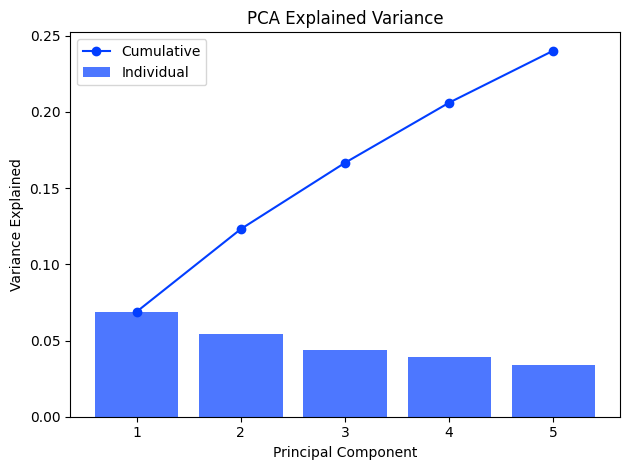

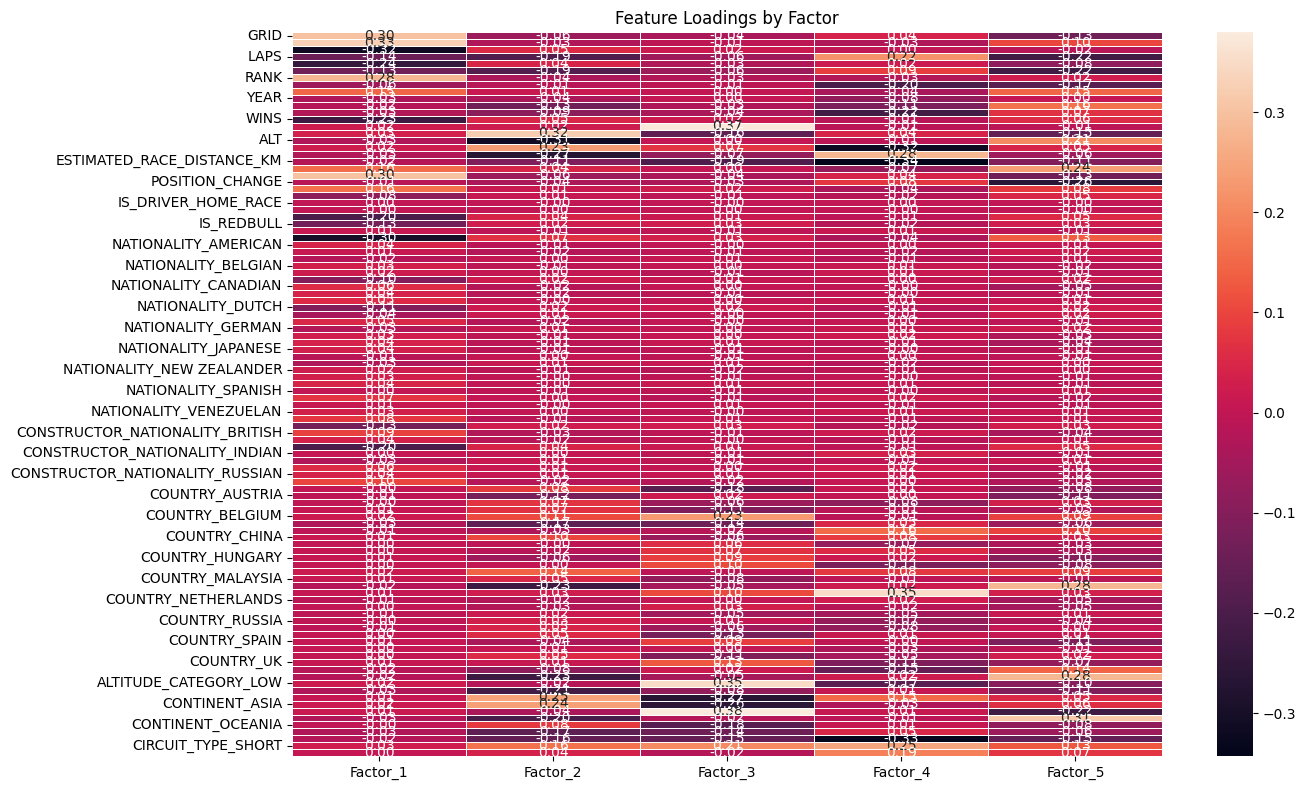


Factor_1 (Explains 6.89% of variance)
Top contributing features:
  - POSITIONORDER: 0.326
  - POINTS: 0.317
  - GRID_ADVANTAGE: 0.301
  - POLE_GAP: 0.301
  - GRID: 0.301
  - RANK: 0.278

Factor_2 (Explains 5.42% of variance)
Top contributing features:
  - LNG: 0.321
  - ALT: 0.310
  - AVG_RACE_LAPS: 0.268
  - ALTITUDE_CATEGORY_SEA LEVEL: 0.246
  - CONTINENT_ASIA: 0.240
  - ESTIMATED_LENGTH_KM: 0.235

Factor_3 (Explains 4.35% of variance)
Top contributing features:
  - CONTINENT_EUROPE: 0.380
  - LAT: 0.374
  - ALTITUDE_CATEGORY_LOW: 0.351
  - ALTITUDE_CATEGORY_SEA LEVEL: 0.269
  - CONTINENT_ASIA: 0.261
  - COUNTRY_BELGIUM: 0.231

Factor_4 (Explains 3.95% of variance)
Top contributing features:
  - COUNTRY_MONACO: 0.350
  - ESTIMATED_RACE_DISTANCE_KM: 0.343
  - CIRCUIT_TYPE_LONG: 0.333
  - ESTIMATED_LENGTH_KM: 0.320
  - AVG_RACE_LAPS: 0.282
  - CIRCUIT_TYPE_SHORT: 0.250

Factor_5 (Explains 3.41% of variance)
Top contributing features:
  - CONTINENT_NORTH AMERICA: 0.312
  - ALTITUDE_CAT

C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32532\520441812.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




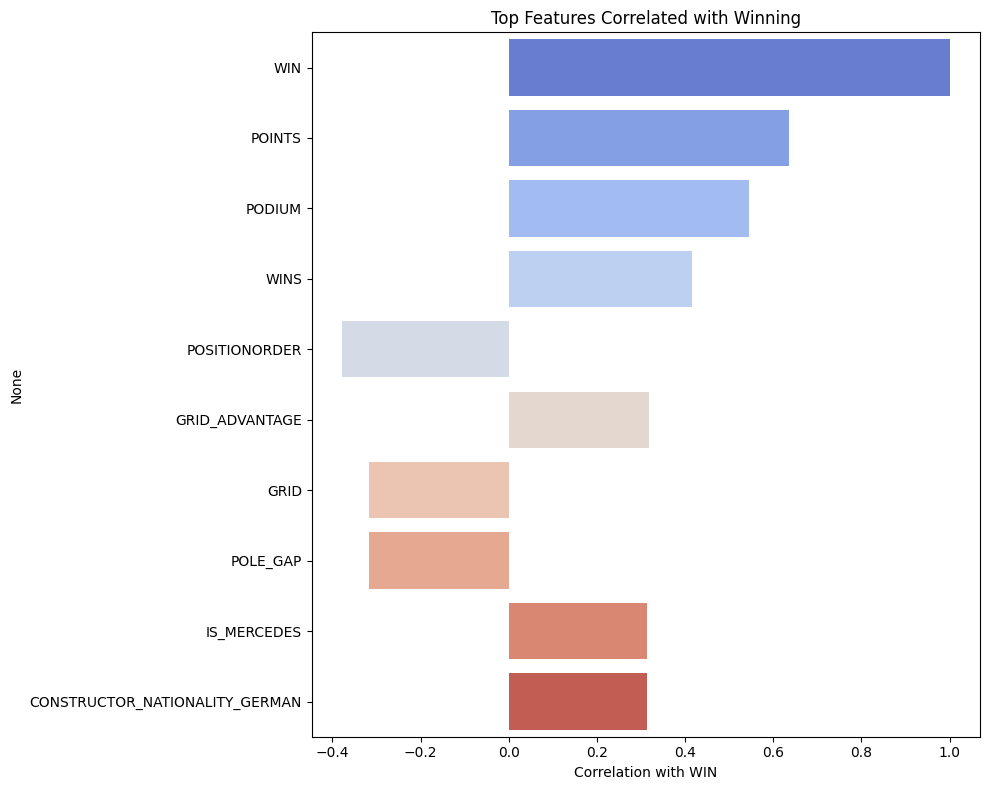

In [ ]:
X_train, X_test, y_train, y_test, feature_cols = split_data_for_modeling(prepared_data, [])

pca, loadings, explained_variance, pca_df = perform_factor_analysis(X_train, feature_cols, n_components=5)
factor_interpretations = interpret_factors(loadings, explained_variance)

for factor, details in factor_interpretations.items():
    print(f'\n{factor} (Explains {details['variance_explained']} of variance)')
    print('Top contributing features:')
    for feature, loading in zip(details['top_features'], details['loadings']):
        print(f'  - {feature}: {loading:.3f}')
plt.figure(figsize=(10, 8))
sns.barplot(x=win_corr.head(10).values, y=win_corr.head(10).index, palette='coolwarm')
plt.title('Top Features Correlated with Winning')
plt.xlabel('Correlation with WIN')
plt.tight_layout()
plt.show()


#### Model 1 - Random Forest Model


R² Score: 0.78


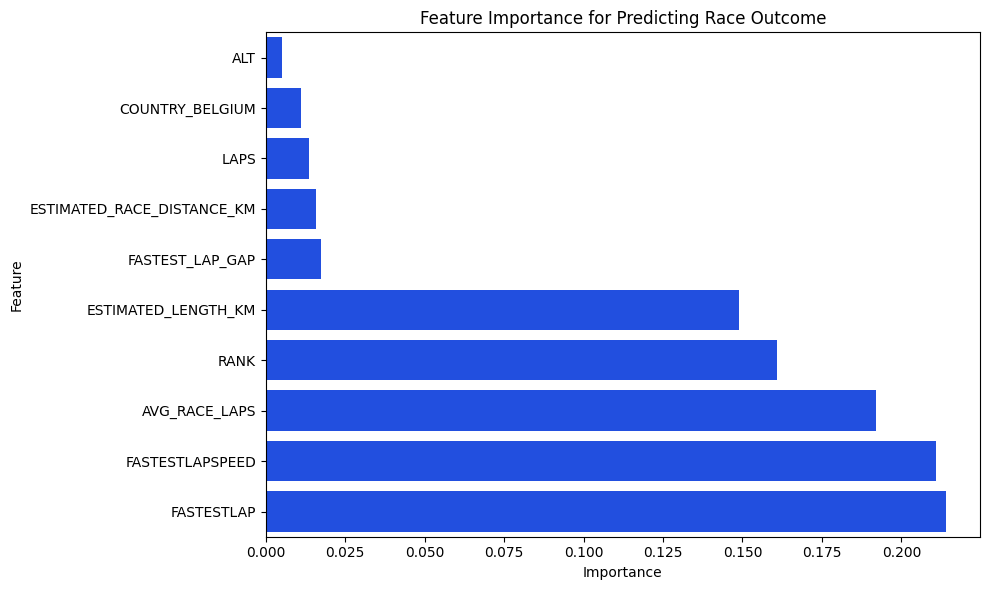

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f'R² Score: {r2_score(y_test, y_pred):.2f}')
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top_features = feature_importance.sort_values(ascending=False).head(10).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Feature Importance for Predicting Race Outcome')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Model 2 - Logistic Regression for Interpretability


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score


# features = [
#     'POLE_GAP', 'FASTESTLAPTIME_SEC', 'POSITION_CHANGE', 'FASTEST_LAP_GAP',
#     'DRIVER_AGE', 'GRID', 'DNF', 'GRID_ADVANTAGE',
#     'IS_MERCEDES', 'IS_REDBULL', 'IS_MCLAREN',
#     'ALTITUDE_CATEGORY_HIGH', 'ALTITUDE_CATEGORY_MEDIUM', 'ALTITUDE_CATEGORY_LOW',
#     # Feel free to add more constructor/country dummies
# ]

target = ['WIN']

X_train, X_test, y_train, y_test, feature_cols = split_data_for_modeling(prepared_data, target)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print('Classification Report:\n', classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}')
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Logistic Regression Coefficients (Impact on Win)')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


NameError: name 'split_data_for_modeling' is not defined

In [ ]:
# Choose features and target
df = prepare_data_for_modeling(df)
feature_cols = ['GRID', 'GRID_ADVANTAGE', 'POSITION_CHANGE',
    'POLE_GAP', 'FASTESTLAPTIME_SEC', 'FASTEST_LAP_GAP',
    'ESTIMATED_RACE_DISTANCE_KM', 'AVG_RACE_LAPS',
    'ALTITUDE_CATEGORY_HIGH', 'ALTITUDE_CATEGORY_LOW', 'ALTITUDE_CATEGORY_SEA LEVEL',
    'IS_MERCEDES', 'IS_REDBULL', 'IS_MCLAREN',
    'DRIVER_AGE', 'PODIUM'] + [col for col in df.columns if col.startswith('LOCATION_') or col.startswith('COUNTRY_') or col.startswith('CIRCUIT_TYPE_')]
X = df[feature_cols].dropna()
y = df.loc[X.index, 'WIN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

print('Logistic Regression Report:\n', classification_report(y_test, logreg.predict(X_test_scaled)))

logreg_importance = pd.Series(logreg.coef_[0], index=feature_cols).sort_values(key=abs, ascending=False)


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       852
           1       1.00      0.87      0.93        46

    accuracy                           0.99       898
   macro avg       1.00      0.93      0.96       898
weighted avg       0.99      0.99      0.99       898



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print('Random Forest Report:\n', classification_report(y_test, rf.predict(X_test)))
rf_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)


Random Forest Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       852
           1       1.00      0.70      0.82        46

    accuracy                           0.98       898
   macro avg       0.99      0.85      0.91       898
weighted avg       0.98      0.98      0.98       898



#### Model 3 - Gradient Boosting Classifier


#### Model 4 - Support Vector Machine


In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)
svm_preds = svm_clf.predict(X_test_scaled)

print(classification_report(y_test, svm_preds))

NameError: name 'X_train_scaled' is not defined

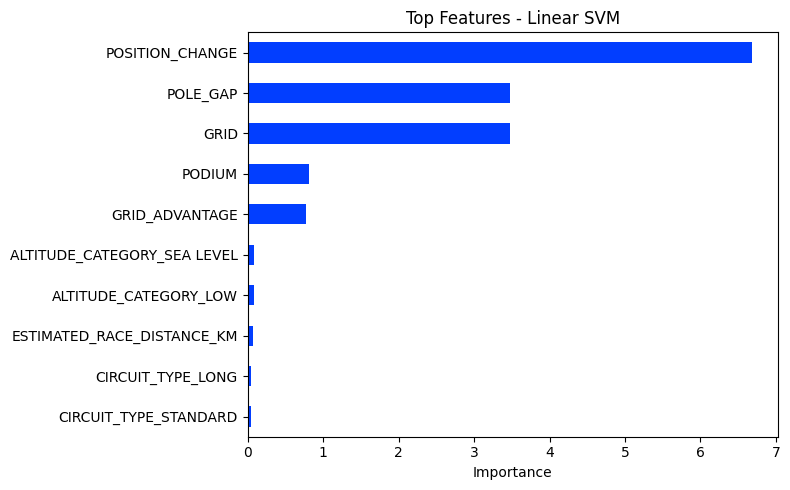

In [ ]:
from sklearn.svm import LinearSVC
def plot_top_features(importance_series, title, top_n=10):
    importance_series.head(top_n).sort_values().plot(
        kind='barh', figsize=(8, 5), title=title
    )
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
linear_svm = LinearSVC(max_iter=10000, random_state=42)
linear_svm.fit(X_train_scaled, y_train)
svm_importance = pd.Series(abs(linear_svm.coef_[0]), index=X_train.columns).sort_values(ascending=False)



#### Model 5 - Neural Network


🔶 Neural Network Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       852
           1       0.85      0.87      0.86        46

    accuracy                           0.99       898
   macro avg       0.92      0.93      0.93       898
weighted avg       0.99      0.99      0.99       898



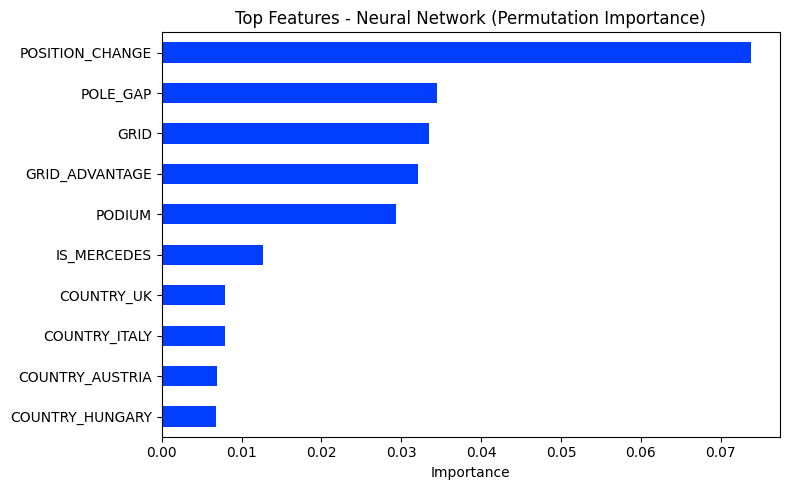

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_preds = mlp.predict(X_test_scaled)

print(classification_report(y_test, mlp_preds))

result = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=10, random_state=42)

nn_importance = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)

### Model Comparison


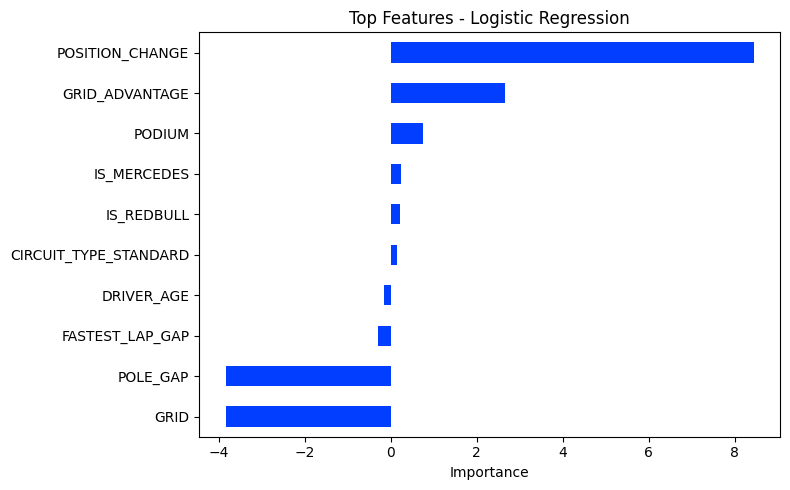

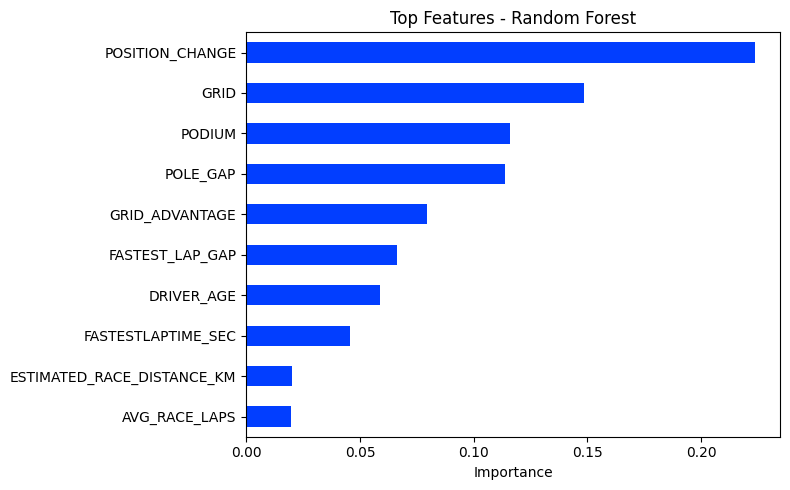

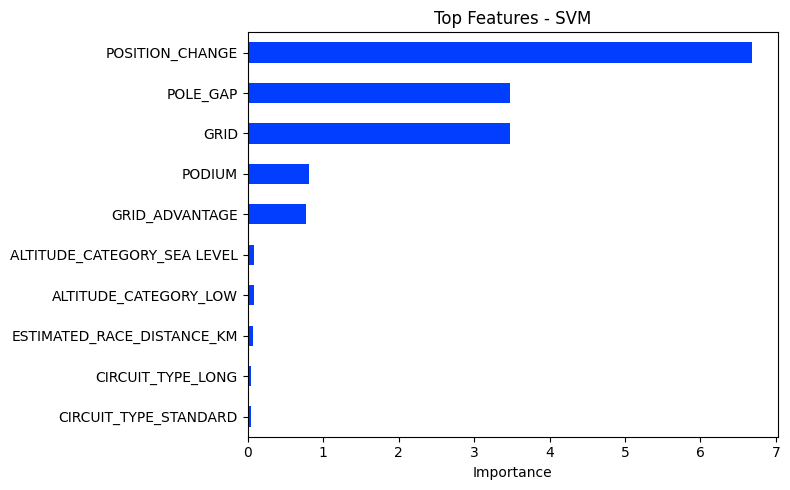

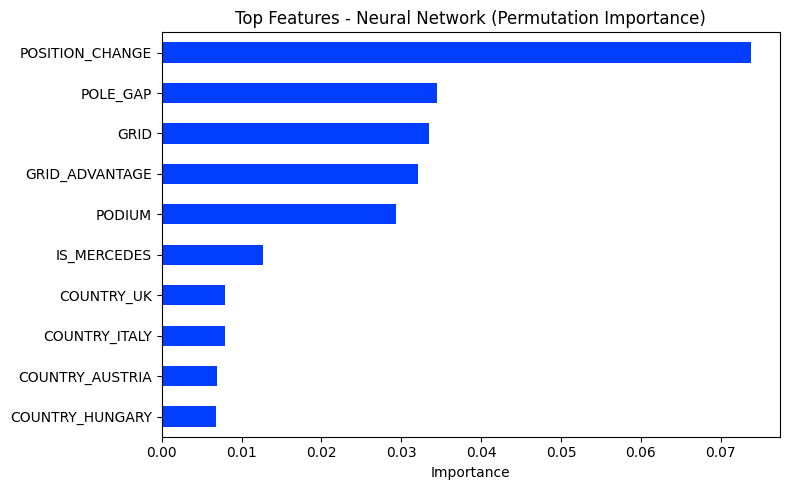

In [ ]:
import matplotlib.pyplot as plt

def plot_top_features(importance_series, title, top_n=10):
    importance_series.head(top_n).sort_values().plot(kind='barh', figsize=(8, 5), title=title)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

plot_top_features(logreg_importance, 'Top Features - Logistic Regression')
plot_top_features(rf_importance, 'Top Features - Random Forest')
plot_top_features(svm_importance, 'Top Features - SVM')
plot_top_features(nn_importance, 'Top Features - Neural Network (Permutation Importance)')


# Key Findings and Insights


# Recommendations and Conclusion
